<a href="https://www.kaggle.com/code/estherokonkwo/breast-cancer-detection?scriptVersionId=290623011" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Hybrid CNN–Transformer Breast Cancer Classification

This notebook focuses on **developing and analyzing hybrid deep learning approach** for **breast cancer image detection**.

We integrate a **ResNet50 convolutional backbone** with a **Vision Transformer (ViT) encoder**, forming a hybrid architecture that captures both **spatial texture features** (from the CNN) and **global contextual relationships** (from the Transformer).

### ⚙️ Environment & Platform Notes

This notebook is designed to run on **Kaggle’s free GPU environment T4 X2 GPU** for efficient training and visualization.

Due to **dataset size and computational requirements**, this notebook may not run efficiently on lightweight environments such as JupyterHub or local setups without dedicated GPUs.

### 📁 Dataset Description

We work with a **curated breast cancer image dataset** stored in
`/kaggle.datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset`, organized into subfolders for each class label.
The dataset includes both mammogram or histopathological images labeled as:

* **Benign (0)**
* **Malignant (1)**

### Model Overview

The model consists of two tightly coupled parts:

1. **ResNet50 (CNN backbone)** – pretrained on ImageNet, fine-tuned for domain-specific feature extraction.
2. **Transformer Encoder Block** – processes patch-wise feature embeddings using Multi-Head Self-Attention (MHSA), allowing global reasoning across spatial features.

This design aims to achieve **higher diagnostic precision** by combining the localization power of CNNs with the global context modeling of Transformers.

### Explainability Integration

To ensure **clinical interpretability**, we integrated two complementary explainability tools:

* **Grad-CAM (CNN-based)** – highlights spatial regions that most influence the CNN feature activations.
* **ViT Attention Maps (Transformer-based)** – visualizes how the self-attention mechanism distributes focus across image patches.

These maps are used to validate whether the model’s attention aligns with clinically relevant tumor regions.

### Runtime & Performance

The full notebook runs in approximately **120 minutes** on a **Kaggle T4 X2 GPU**.
This includes:

* Model building and fine-tuning
* Evaluation and metrics visualization
* Dual explainability analysis (Grad-CAM + ViT attention)

### Import Neccessary Libraries

In [2]:
import os
import PIL
import cv2
import uuid
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import glob as gb
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from math import sqrt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from PIL import Image
from tqdm import tqdm 
from scipy.special import gamma
from tensorflow.keras.metrics import AUC
from sklearn.metrics import confusion_matrix, roc_curve, auc,roc_auc_score
from keras.optimizers import *
from keras.regularizers import l1_l2
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping,LearningRateScheduler
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input,GlobalAveragePooling2D, Dense, Dropout
from keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.metrics import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2026-01-07 22:31:17.410504: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767825077.939155      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767825078.088071      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Load the data.

In [3]:
calc_train = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/calc_case_description_train_set.csv')
calc_test = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/calc_case_description_test_set.csv')
mass_train = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_train_set.csv')
mass_test = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_test_set.csv')
dicom_df = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/dicom_info.csv')

### Exploratory Data Analysis

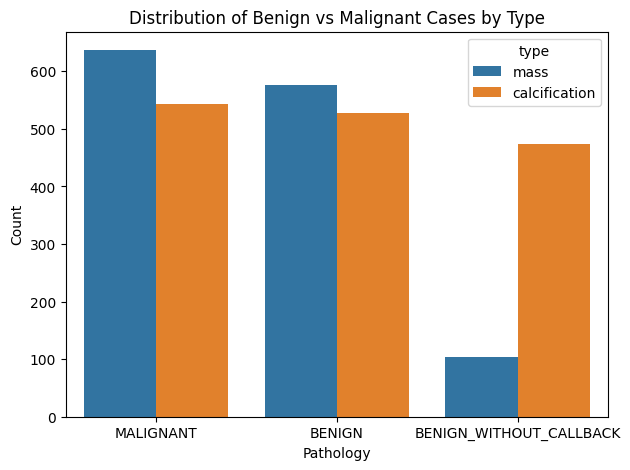

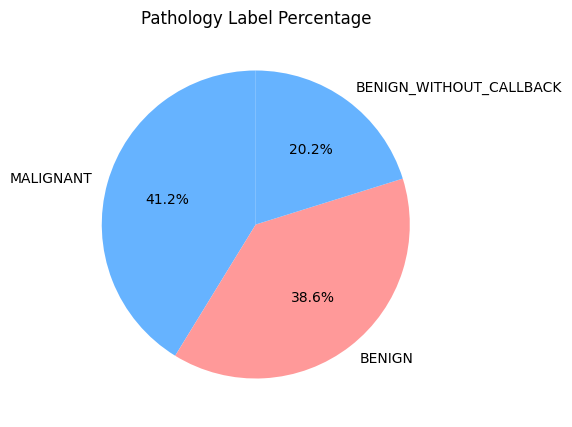

In [4]:
mass_train['type'] = 'mass'
calc_train['type'] = 'calcification'
all_data = pd.concat([mass_train, calc_train], ignore_index=True)

plt.figure(figsize=(7,5))
sns.countplot(x='pathology', hue='type', data=all_data)
plt.title('Distribution of Benign vs Malignant Cases by Type')
plt.xlabel('Pathology')
plt.ylabel('Count')
plt.show()

path_counts = all_data['pathology'].value_counts()
plt.figure(figsize=(5,5))
plt.pie(path_counts, labels=path_counts.index, autopct='%1.1f%%', startangle=90,
        colors=['#66b3ff','#ff9999'])
plt.title('Pathology Label Percentage')
plt.show()


Average Width: 2133.4, Average Height: 3435.2


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


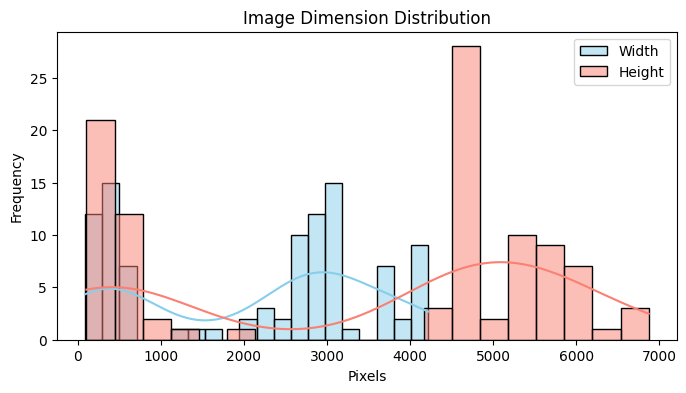

In [5]:
from PIL import Image
import glob
import numpy as np
import seaborn as sns


IMG_ROOT = "/kaggle/input/cbis-ddsm-breast-cancer-image-dataset"

sample_paths = glob.glob(f"{IMG_ROOT}/**/*.jpg", recursive=True)[:100]

sizes = [Image.open(p).size for p in sample_paths]
widths, heights = zip(*sizes)

print(f"Average Width: {np.mean(widths):.1f}, Average Height: {np.mean(heights):.1f}")

plt.figure(figsize=(8,4))
sns.histplot(widths, bins=20, color='skyblue', label='Width', kde=True)
sns.histplot(heights, bins=20, color='salmon', label='Height', kde=True)
plt.legend()
plt.title("Image Dimension Distribution")
plt.xlabel("Pixels")
plt.ylabel("Frequency")
plt.show()


## Replace_path

We replace instances of old_path and new_path with the input sample string, which allows for regex pattern matching. 

In [6]:
def replace_path(sample, old_path, new_path):
    return sample.replace(old_path, new_path, regex=True)

In [7]:
def plot_smaples(sample, row=15, col=15):
    plt.figure(figsize=(row, col))
    for i, file in enumerate(sample[0:5]):
        cropped_images_show = PIL.Image.open(file)
        gray_img= cropped_images_show.convert("L")
        plt.subplot(1,5,i+1)
        plt.imshow(gray_img, cmap='gray')
        plt.axis('off')
    plt.show()

In [8]:
cropped_images = dicom_df[dicom_df.SeriesDescription=="cropped images"].image_path
full_mammogram = dicom_df[dicom_df.SeriesDescription=="full mammogram images"].image_path
roi_mask = dicom_df[dicom_df.SeriesDescription=="ROI mask images"].image_path

In [9]:
correct_dir = "../input/cbis-ddsm-breast-cancer-image-dataset/jpeg"
cropped_images = replace_path(cropped_images, "CBIS-DDSM/jpeg", correct_dir)
print('Cropped Images paths:')
print(cropped_images.iloc[0]) # Print to ensure everything looks correct.

Cropped Images paths:
../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg


In [10]:
full_mammogram = replace_path(full_mammogram, "CBIS-DDSM/jpeg", correct_dir)
print('\nFull mammo Images paths:')
print(full_mammogram.iloc[0]) # Print to ensure everything looks correct.


Full mammo Images paths:
../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg


In [11]:
roi_mask = replace_path(roi_mask, "CBIS-DDSM/jpeg", correct_dir)
print('\nROI Mask Images paths:')
print(roi_mask.iloc[0]) # Print to ensure everything looks correct.


ROI Mask Images paths:
../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg


Here we are creating a "get_image_file_name" function to find the length of each dataset, and ensure this matches and all pictures are implemented as expected.

In [12]:
def get_image_file_name(data, new_dict):

    for dicom in data:
        key = dicom.split('/')[4]
        new_dict[key] = dicom
    print(f"the length of dataset ==> {len(new_dict.keys())}")

In [13]:
cropped_images_dict = dict()
full_mammo_dict = dict()
roi_img_dict = dict()

get_image_file_name(cropped_images, cropped_images_dict)
get_image_file_name(full_mammogram, full_mammo_dict)
get_image_file_name(roi_mask, roi_img_dict)

the length of dataset ==> 3567
the length of dataset ==> 2857
the length of dataset ==> 3247


In [14]:
def fix_image_path(data):
    """Correct dicom paths to correct image paths."""
    for indx, image in enumerate(data.values):

        img_name = image[11].split('/')[2]

        if img_name in full_mammo_dict:
            data.iloc[indx, 11] = full_mammo_dict[img_name]
        else:
            data.iloc[indx, 11] = None
        
        img_name = image[12].split('/')[2]
        if img_name in cropped_images_dict:
            data.iloc[indx, 12] = cropped_images_dict[img_name]
        else:
            data.iloc[indx, 11] = None

        img_name = image[13].split('/')[2]
        if img_name in roi_img_dict:
            data.iloc[indx, 13] = roi_img_dict[img_name]

        else:
            data.iloc[indx, 13] = None

## Image file paths

We fix the image file paths for mass_train, mass_test, calc_train, and calc_test.

In [15]:
fix_image_path(mass_train)

In [16]:
mass_train = mass_train.rename(columns={'left or right breast': 'left_or_right_breast',
                                        'image view': 'image_view',
                                        'abnormality id': 'abnormality_id',
                                        'abnormality type': 'abnormality_type',
                                        'mass shape': 'mass_shape',
                                        'mass margins': 'mass_margins',
                                        'image file path': 'image_file_path',
                                        'cropped image file path': 'cropped_image_file_path',
                                        'ROI mask file path': 'ROI_mask_file_path'})
mass_train.head(5)

patient_id  breast_density left_or_right_breast image_view  abnormality_id  \
0    P_00001               3                 LEFT         CC               1   
1    P_00001               3                 LEFT        MLO               1   
2    P_00004               3                 LEFT         CC               1   
3    P_00004               3                 LEFT        MLO               1   
4    P_00004               3                RIGHT        MLO               1   

  abnormality_type                          mass_shape   mass_margins  \
0             mass  IRREGULAR-ARCHITECTURAL_DISTORTION     SPICULATED   
1             mass  IRREGULAR-ARCHITECTURAL_DISTORTION     SPICULATED   
2             mass            ARCHITECTURAL_DISTORTION    ILL_DEFINED   
3             mass            ARCHITECTURAL_DISTORTION    ILL_DEFINED   
4             mass                                OVAL  CIRCUMSCRIBED   

   assessment  pathology  subtlety  \
0           4  MALIGNANT         4   
1           4  MALIGNANT         4   
2           4     BENIGN         3   
3           4     BENIGN         3   
4           4     BENIGN         5   

                                     image_file_path  \
0  ../input/cbis-ddsm-breast-cancer-image-dataset...   
1  ../input/cbis-ddsm-breast-cancer-image-dataset...   
2  ../input/cbis-ddsm-breast-cancer-image-dataset...   
3  ../input/cbis-ddsm-breast-cancer-image-dataset...   
4  ../input/cbis-ddsm-breast-cancer-image-dataset...   

                             cropped_image_file_path  \
0  ../input/cbis-ddsm-breast-cancer-image-dataset...   
1  ../input/cbis-ddsm-breast-cancer-image-dataset...   
2  ../input/cbis-ddsm-breast-cancer-image-dataset...   
3  ../input/cbis-ddsm-breast-cancer-image-dataset...   
4  ../input/cbis-ddsm-breast-cancer-image-dataset...   

                                  ROI_mask_file_path  type  
0  ../input/cbis-ddsm-breast-cancer-image-dataset...  mass  
1  ../input/cbis-ddsm-breast-cancer-image-dataset...  mass  
2  ../input/cbis-ddsm-breast-cancer-image-dataset...  mass  
3  ../input/cbis-ddsm-breast-cancer-image-dataset...  mass  
4  ../input/cbis-ddsm-breast-cancer-image-dataset...  mass

In [17]:
mass_train.pathology.unique()

array(['MALIGNANT', 'BENIGN', 'BENIGN_WITHOUT_CALLBACK'], dtype=object)

In [18]:
fix_image_path(mass_test)

In [19]:
mass_test = mass_test.rename(columns={'left or right breast': 'left_or_right_breast',
                                      'image view': 'image_view',
                                      'abnormality id': 'abnormality_id',
                                      'abnormality type': 'abnormality_type',
                                      'mass shape': 'mass_shape',
                                      'mass margins': 'mass_margins',
                                      'image file path': 'image_file_path',
                                      'cropped image file path': 'cropped_image_file_path',
                                      'ROI mask file path': 'ROI_mask_file_path'})
mass_test.head()

patient_id  breast_density left_or_right_breast image_view  abnormality_id  \
0    P_00016               4                 LEFT         CC               1   
1    P_00016               4                 LEFT        MLO               1   
2    P_00017               2                 LEFT         CC               1   
3    P_00017               2                 LEFT        MLO               1   
4    P_00032               3                RIGHT         CC               1   

  abnormality_type mass_shape   mass_margins  assessment  pathology  subtlety  \
0             mass  IRREGULAR     SPICULATED           5  MALIGNANT         5   
1             mass  IRREGULAR     SPICULATED           5  MALIGNANT         5   
2             mass      ROUND  CIRCUMSCRIBED           4  MALIGNANT         4   
3             mass      ROUND    ILL_DEFINED           4  MALIGNANT         4   
4             mass      ROUND       OBSCURED           0     BENIGN         2   

                                     image_file_path  \
0  ../input/cbis-ddsm-breast-cancer-image-dataset...   
1  ../input/cbis-ddsm-breast-cancer-image-dataset...   
2  ../input/cbis-ddsm-breast-cancer-image-dataset...   
3  ../input/cbis-ddsm-breast-cancer-image-dataset...   
4  ../input/cbis-ddsm-breast-cancer-image-dataset...   

                             cropped_image_file_path  \
0  ../input/cbis-ddsm-breast-cancer-image-dataset...   
1  ../input/cbis-ddsm-breast-cancer-image-dataset...   
2  ../input/cbis-ddsm-breast-cancer-image-dataset...   
3  ../input/cbis-ddsm-breast-cancer-image-dataset...   
4  ../input/cbis-ddsm-breast-cancer-image-dataset...   

                                  ROI_mask_file_path  
0  ../input/cbis-ddsm-breast-cancer-image-dataset...  
1  ../input/cbis-ddsm-breast-cancer-image-dataset...  
2  ../input/cbis-ddsm-breast-cancer-image-dataset...  
3  ../input/cbis-ddsm-breast-cancer-image-dataset...  
4  ../input/cbis-ddsm-breast-cancer-image-dataset...

In [20]:
calc_train = calc_train.rename(columns={'left or right breast': 'left_or_right_breast',
                                        'image view': 'image_view',
                                        'abnormality id': 'abnormality_id',
                                        'abnormality type': 'abnormality_type',
                                        'mass shape': 'mass_shape',
                                        'mass margins': 'mass_margins',
                                        'image file path': 'image_file_path',
                                        'cropped image file path': 'cropped_image_file_path',
                                        'ROI mask file path': 'ROI_mask_file_path'})
calc_train.head()

patient_id  breast density left_or_right_breast image_view  abnormality_id  \
0    P_00005               3                RIGHT         CC               1   
1    P_00005               3                RIGHT        MLO               1   
2    P_00007               4                 LEFT         CC               1   
3    P_00007               4                 LEFT        MLO               1   
4    P_00008               1                 LEFT         CC               1   

  abnormality_type    calc type calc distribution  assessment  \
0    calcification    AMORPHOUS         CLUSTERED           3   
1    calcification    AMORPHOUS         CLUSTERED           3   
2    calcification  PLEOMORPHIC            LINEAR           4   
3    calcification  PLEOMORPHIC            LINEAR           4   
4    calcification          NaN          REGIONAL           2   

                 pathology  subtlety  \
0                MALIGNANT         3   
1                MALIGNANT         3   
2                   BENIGN         4   
3                   BENIGN         4   
4  BENIGN_WITHOUT_CALLBACK         3   

                                     image_file_path  \
0  Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...   
1  Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...   
2  Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590...   
3  Calc-Training_P_00007_LEFT_MLO/1.3.6.1.4.1.959...   
4  Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...   

                             cropped_image_file_path  \
0  Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...   
1  Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....   
2  Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...   
3  Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...   
4  Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...   

                                  ROI_mask_file_path           type  
0  Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...  calcification  
1  Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....  calcification  
2  Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...  calcification  
3  Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...  calcification  
4  Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...  calcification

In [21]:
fix_image_path(calc_train)

In [22]:
calc_test = calc_test.rename(columns={'left or right breast': 'left_or_right_breast',
                                      'image view': 'image_view',
                                      'abnormality id': 'abnormality_id',
                                      'abnormality type': 'abnormality_type',
                                      'mass shape': 'mass_shape',
                                      'mass margins': 'mass_margins',
                                      'image file path': 'image_file_path',
                                      'cropped image file path': 'cropped_image_file_path',
                                      'ROI mask file path': 'ROI_mask_file_path'})
calc_test.head()

patient_id  breast density left_or_right_breast image_view  abnormality_id  \
0    P_00038               2                 LEFT         CC               1   
1    P_00038               2                 LEFT        MLO               1   
2    P_00038               2                RIGHT         CC               1   
3    P_00038               2                RIGHT         CC               2   
4    P_00038               2                RIGHT        MLO               1   

  abnormality_type             calc type calc distribution  assessment  \
0    calcification  PUNCTATE-PLEOMORPHIC         CLUSTERED           4   
1    calcification  PUNCTATE-PLEOMORPHIC         CLUSTERED           4   
2    calcification              VASCULAR               NaN           2   
3    calcification              VASCULAR               NaN           2   
4    calcification              VASCULAR               NaN           2   

                 pathology  subtlety  \
0                   BENIGN         2   
1                   BENIGN         2   
2  BENIGN_WITHOUT_CALLBACK         5   
3  BENIGN_WITHOUT_CALLBACK         5   
4  BENIGN_WITHOUT_CALLBACK         5   

                                     image_file_path  \
0  Calc-Test_P_00038_LEFT_CC/1.3.6.1.4.1.9590.100...   
1  Calc-Test_P_00038_LEFT_MLO/1.3.6.1.4.1.9590.10...   
2  Calc-Test_P_00038_RIGHT_CC/1.3.6.1.4.1.9590.10...   
3  Calc-Test_P_00038_RIGHT_CC/1.3.6.1.4.1.9590.10...   
4  Calc-Test_P_00038_RIGHT_MLO/1.3.6.1.4.1.9590.1...   

                             cropped_image_file_path  \
0  Calc-Test_P_00038_LEFT_CC_1/1.3.6.1.4.1.9590.1...   
1  Calc-Test_P_00038_LEFT_MLO_1/1.3.6.1.4.1.9590....   
2  Calc-Test_P_00038_RIGHT_CC_1/1.3.6.1.4.1.9590....   
3  Calc-Test_P_00038_RIGHT_CC_2/1.3.6.1.4.1.9590....   
4  Calc-Test_P_00038_RIGHT_MLO_1/1.3.6.1.4.1.9590...   

                                  ROI_mask_file_path  
0  Calc-Test_P_00038_LEFT_CC_1/1.3.6.1.4.1.9590.1...  
1  Calc-Test_P_00038_LEFT_MLO_1/1.3.6.1.4.1.9590....  
2  Calc-Test_P_00038_RIGHT_CC_1/1.3.6.1.4.1.9590....  
3  Calc-Test_P_00038_RIGHT_CC_2/1.3.6.1.4.1.9590....  
4  Calc-Test_P_00038_RIGHT_MLO_1/1.3.6.1.4.1.9590...

In [23]:
fix_image_path(calc_test)

Data handling
We handle the missing files and converting formats accordingly.

In [24]:
def display_images(dataset, column, number):    
    fig, axes = plt.subplots(1, number, figsize=(15, 5))
    
    for index, (i, row) in enumerate(dataset.head(number).iterrows()):
        image_path = row[column]
        
        if image_path is None or not os.path.exists(image_path):
            continue
        
        image = cv2.imread(image_path)
        
        if image is None:
            continue
        
        if len(image.shape) == 3 and image.shape[2] == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        ax = axes[index]
        ax.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
        ax.set_title(f"{row['pathology']}")
        ax.axis('off')
        print(np.array(image).shape)
    
    plt.tight_layout()
    plt.show()

Full Mammograms:

(4808, 3024, 3)
(4800, 2656, 3)
(5491, 2986, 3)
(5491, 3046, 3)
(5491, 2911, 3)


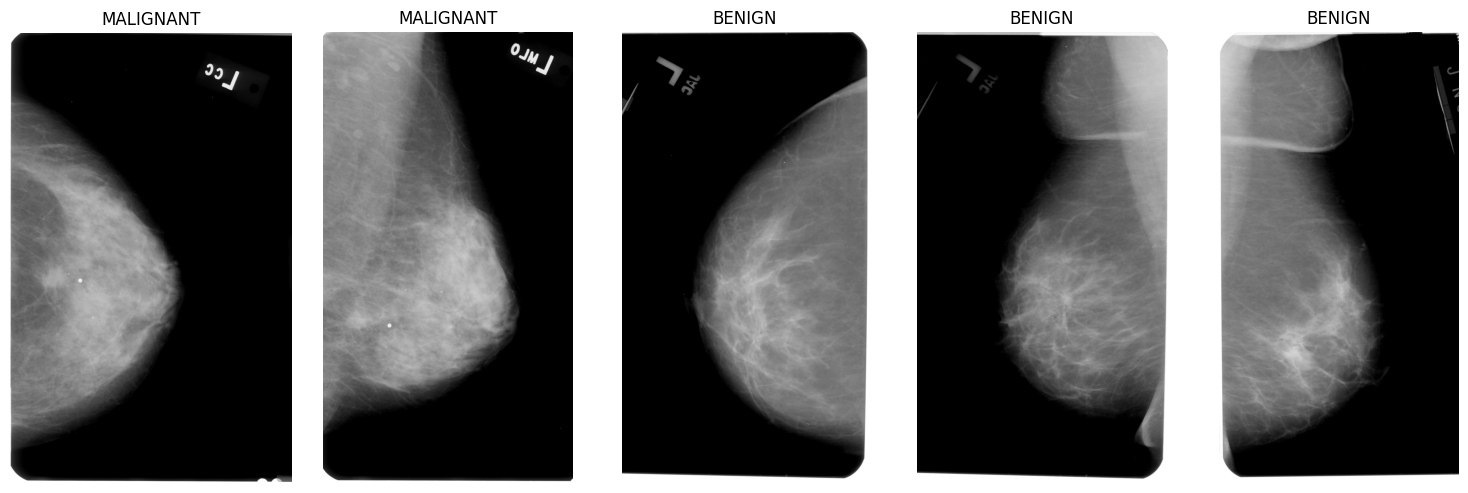

Cropped Mammograms:

(515, 431, 3)
(292, 256, 3)
(466, 423, 3)
(427, 422, 3)
(399, 465, 3)


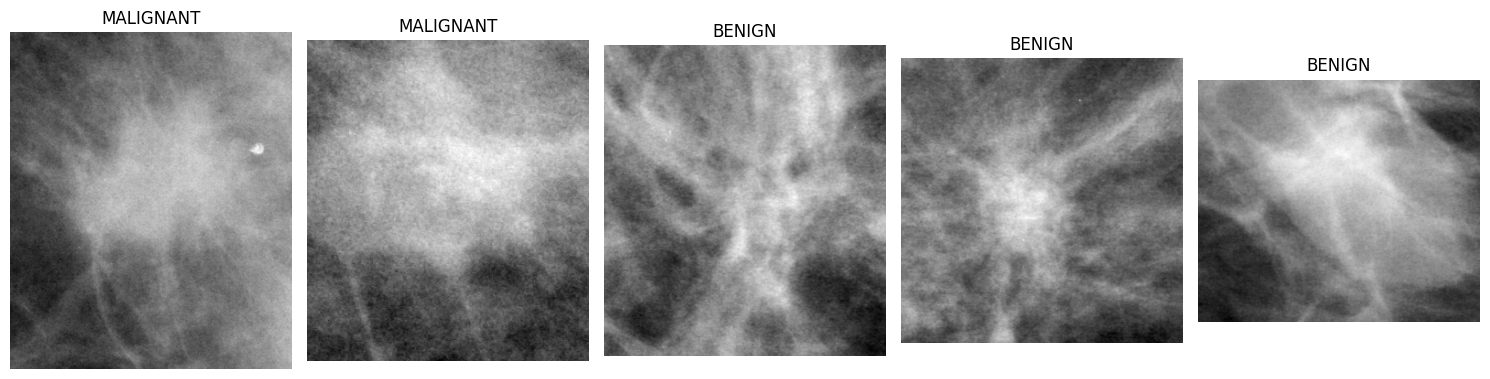

ROI_mask:

(4808, 3024, 3)
(4800, 2656, 3)
(5491, 2986, 3)
(5491, 3046, 3)
(5491, 2911, 3)


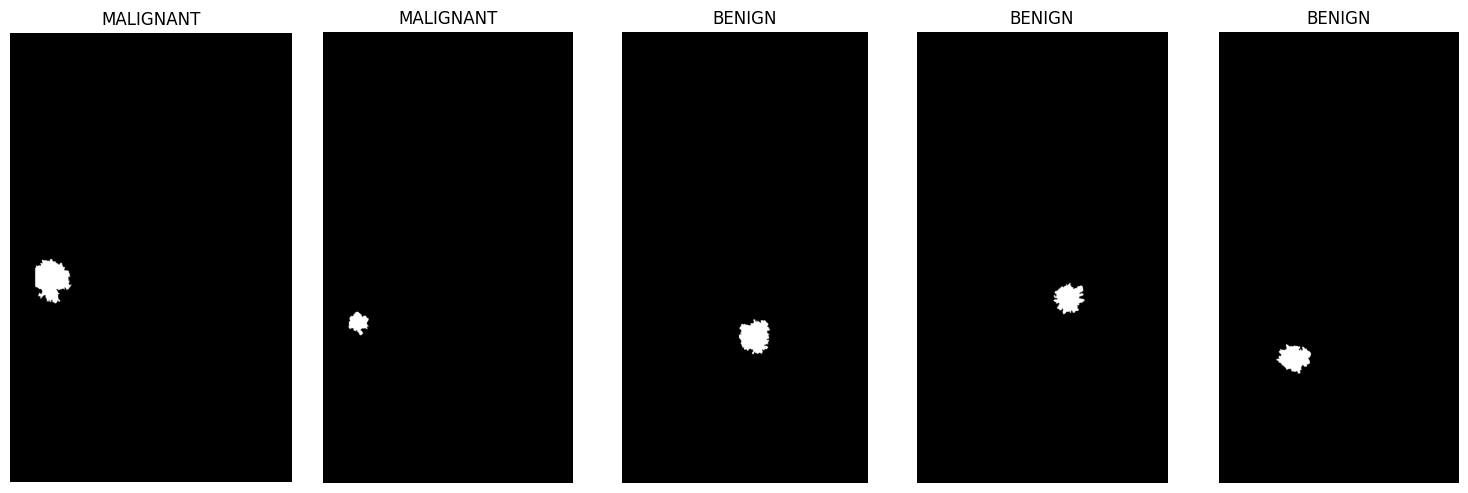

In [25]:
print('Full Mammograms:\n')
display_images(mass_train, 'image_file_path', 5)
print('Cropped Mammograms:\n')
display_images(mass_train, 'cropped_image_file_path', 5)
print('ROI_mask:\n')
display_images(mass_train, 'ROI_mask_file_path', 5)

Full Mammograms:

(4006, 1846, 3)
(5491, 2011, 3)
(5904, 3200, 3)
(5952, 3352, 3)
(5116, 2641, 3)


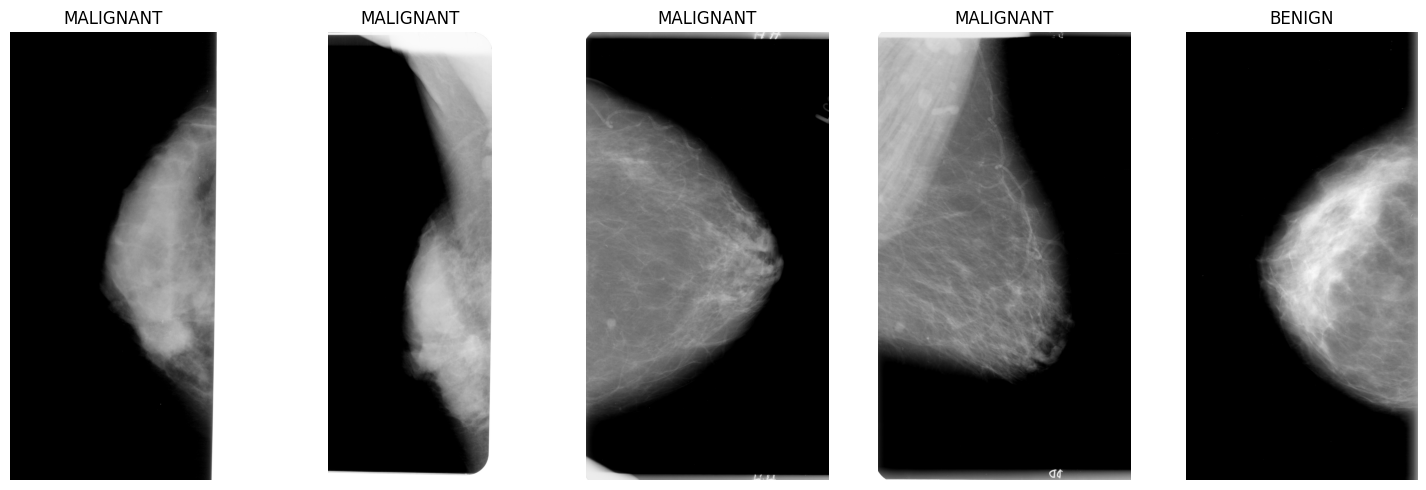

Cropped Mammograms:

(384, 385, 3)
(369, 328, 3)
(214, 195, 3)
(220, 225, 3)
(405, 376, 3)


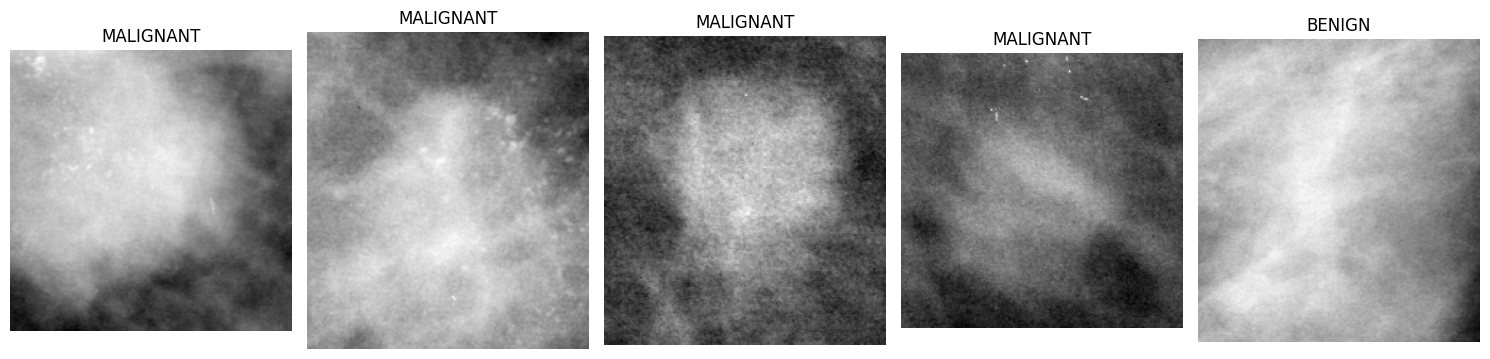

ROI_mask:

(4006, 1846, 3)
(5491, 2011, 3)
(5904, 3200, 3)
(5952, 3352, 3)
(5116, 2641, 3)


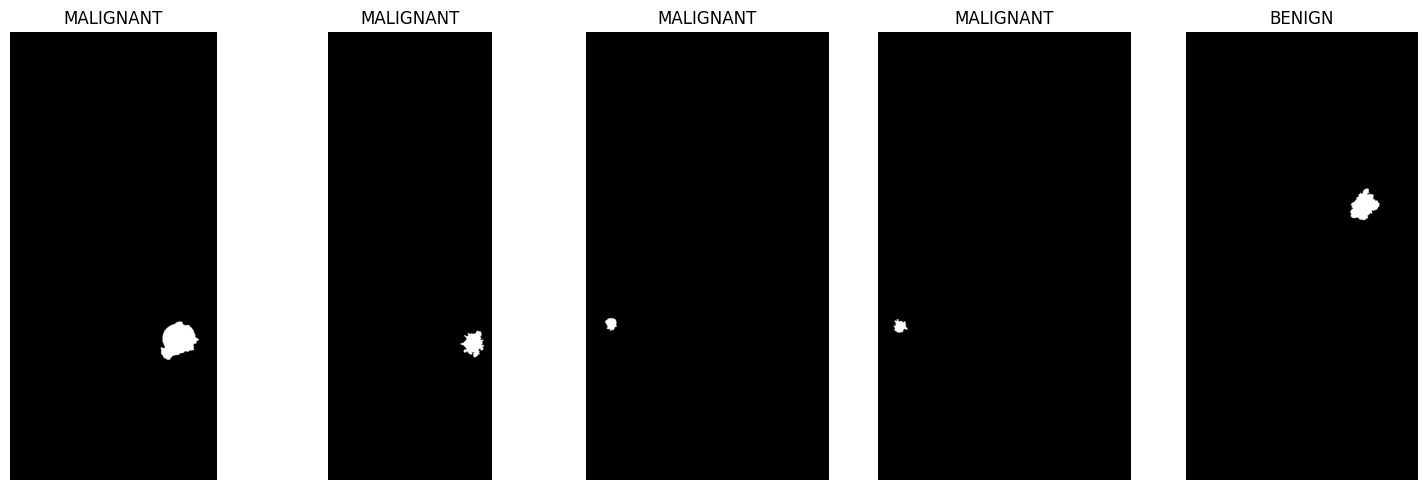

In [26]:
print('Full Mammograms:\n')
display_images(mass_test, 'image_file_path', 5)
print('Cropped Mammograms:\n')
display_images(mass_test, 'cropped_image_file_path', 5)
print('ROI_mask:\n')
display_images(mass_test, 'ROI_mask_file_path', 5)

Full Mammograms:

(5056, 2761, 3)
(5386, 2836, 3)
(5356, 2986, 3)
(5491, 3166, 3)
(4568, 3064, 3)


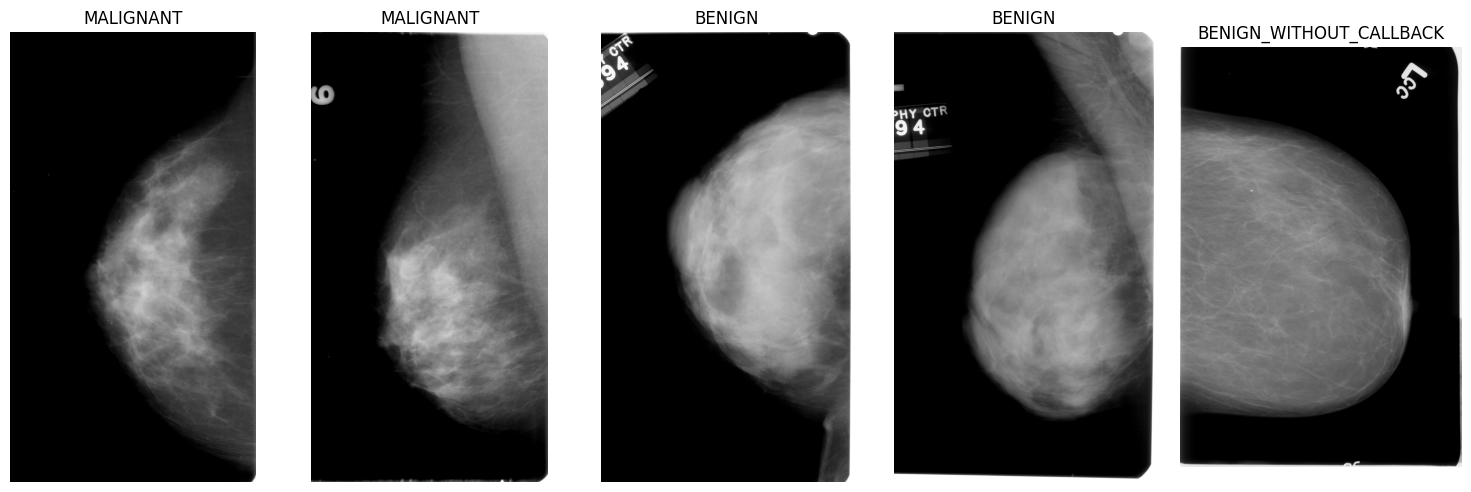

Cropped Mammograms:

(589, 677, 3)
(549, 681, 3)
(681, 577, 3)
(689, 761, 3)
(161, 177, 3)


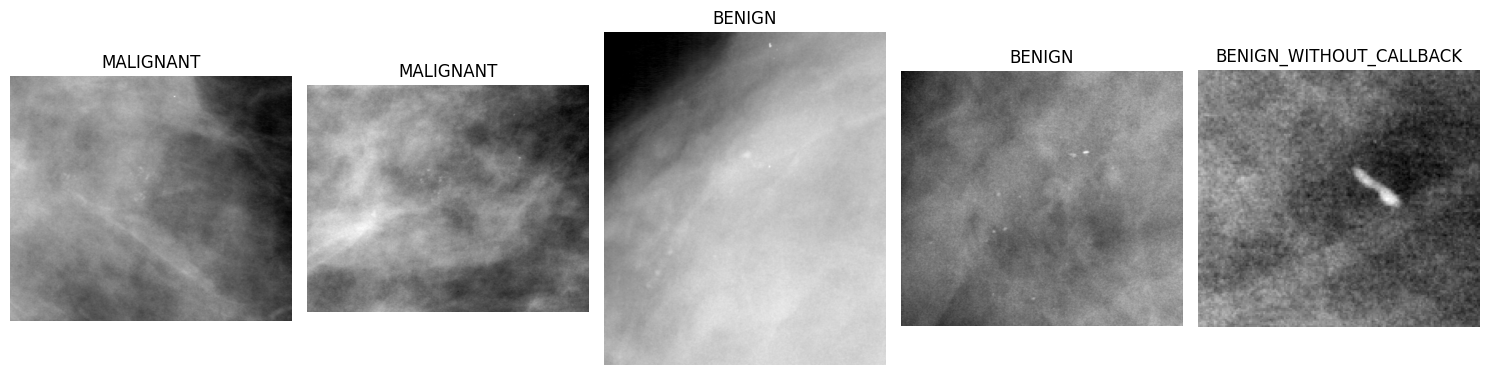

ROI_mask:

(5056, 2761, 3)
(5386, 2836, 3)
(5356, 2986, 3)
(5491, 3166, 3)
(4568, 3064, 3)


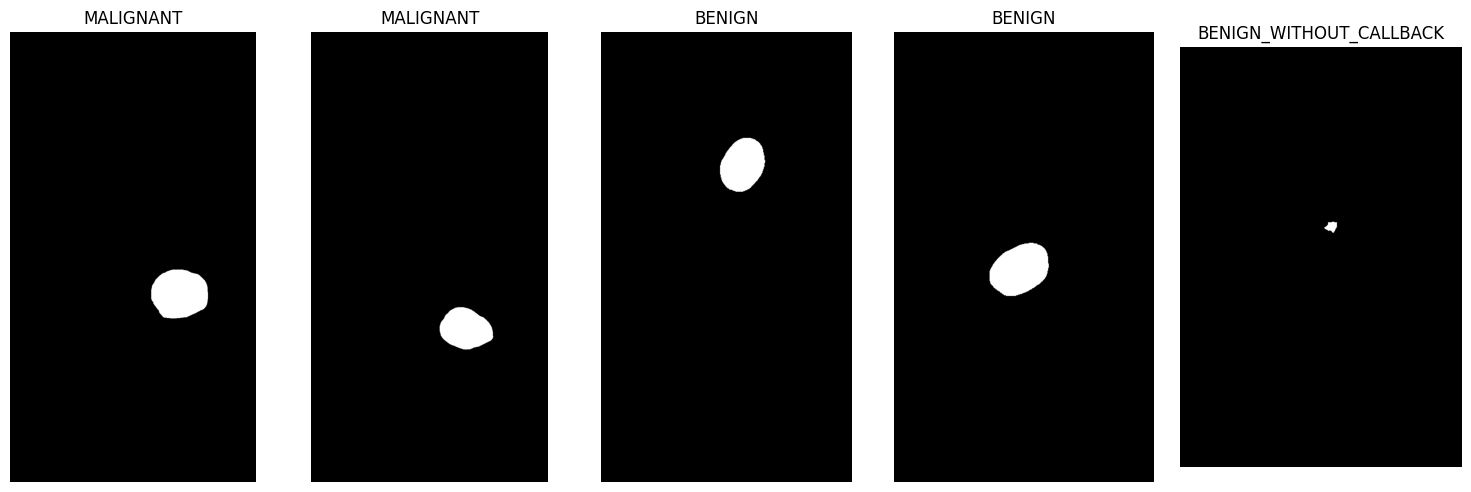

In [27]:
print('Full Mammograms:\n')
display_images(calc_train, 'image_file_path', 5)
print('Cropped Mammograms:\n')
display_images(calc_train, 'cropped_image_file_path', 5)
print('ROI_mask:\n')
display_images(calc_train, 'ROI_mask_file_path', 5)

Full Mammograms:



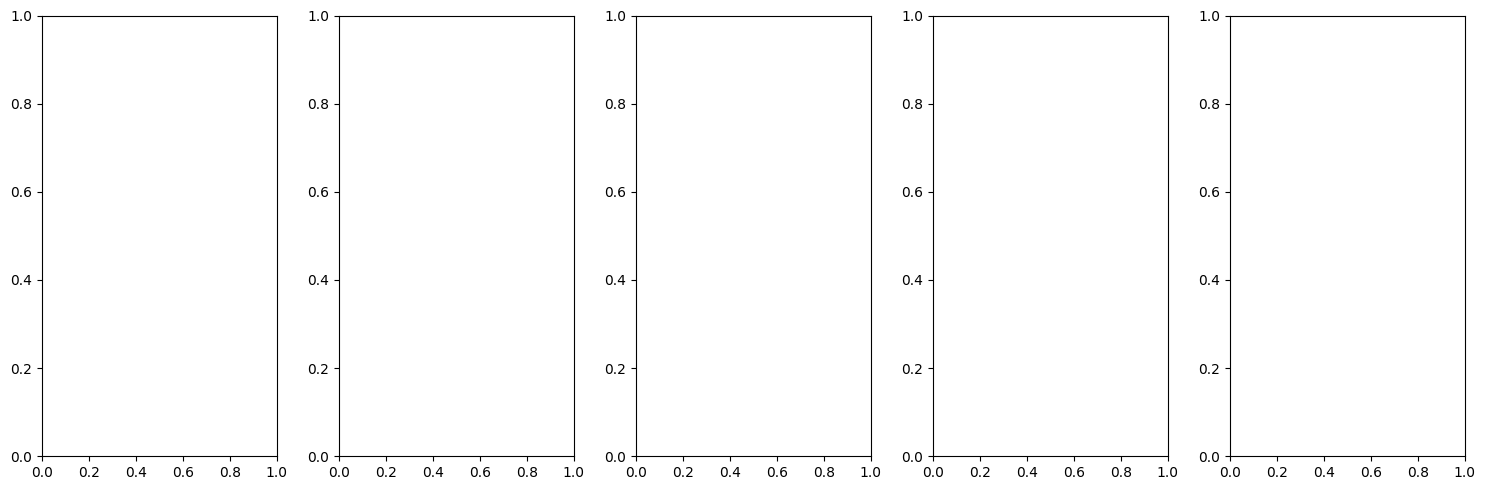

Cropped Mammograms:

(249, 265, 3)
(265, 249, 3)
(409, 660, 3)
(257, 724, 3)
(809, 833, 3)


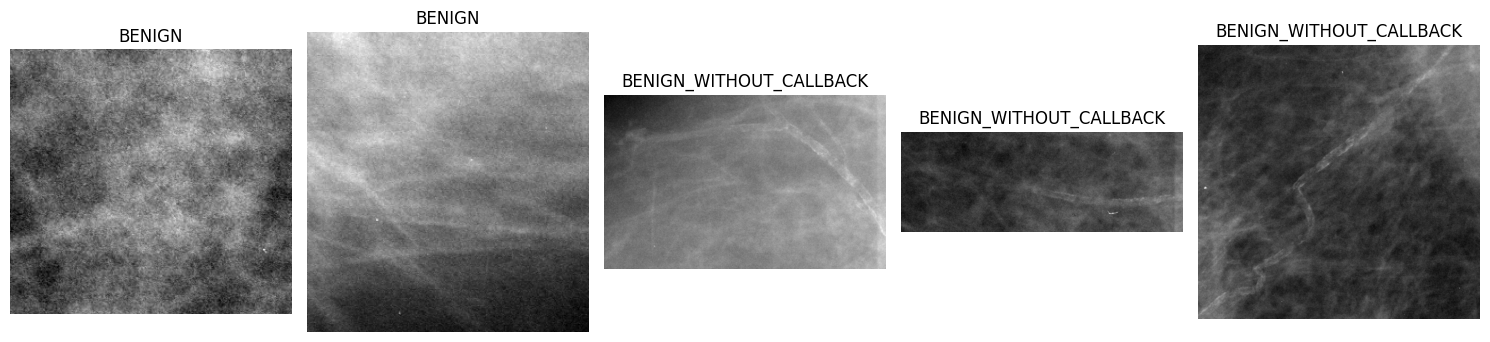

ROI_mask:



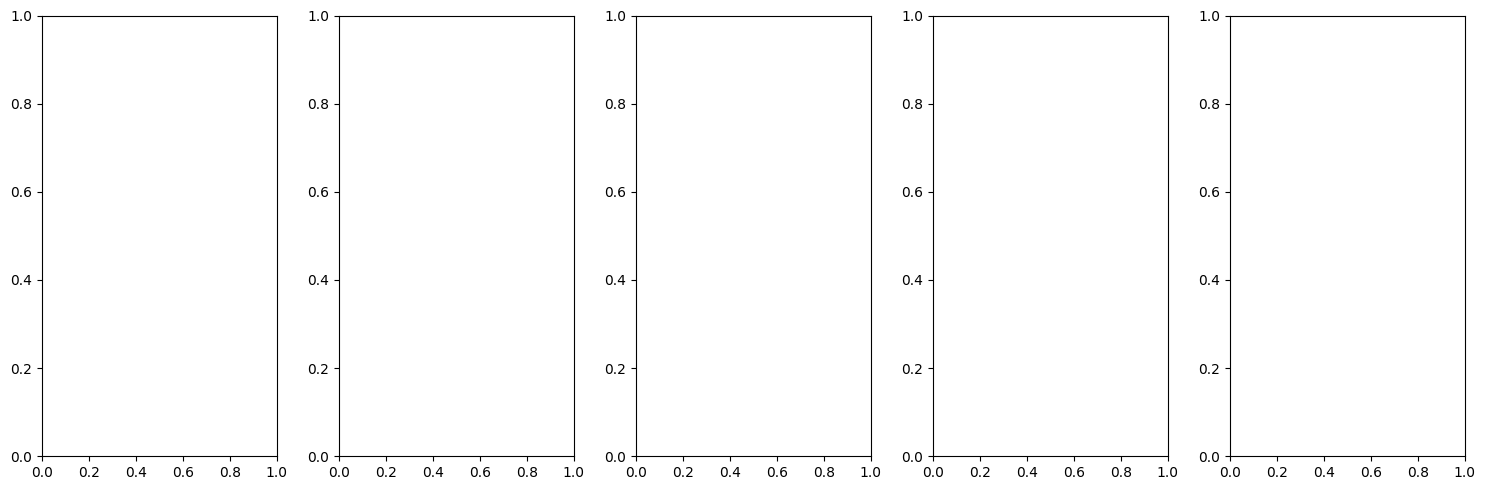

In [28]:
print('Full Mammograms:\n')
display_images(calc_test, 'image_file_path', 5)
print('Cropped Mammograms:\n')
display_images(calc_test, 'cropped_image_file_path', 5)
print('ROI_mask:\n')
display_images(calc_test, 'ROI_mask_file_path', 5)

We combine the datasets into one.

In [29]:
full_dataset = pd.concat([calc_train, calc_test], axis=0)

In [30]:
len(full_dataset)

1872

# Mapping each class. 

We're treating BENIGN_WITHOUT_CALLBACK as 0 as well.

In [31]:
class_mapper = {'MALIGNANT': 1, 'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 0} 

In [32]:
target_size = (224, 224, 3)

full_dataset['labels'] = full_dataset['pathology'].replace(class_mapper).infer_objects(copy=False)

full_images = np.array(full_dataset[full_dataset["image_file_path"].notna()]["image_file_path"].tolist())
full_labels = np.array(full_dataset[full_dataset["image_file_path"].notna()]["labels"].tolist())

/tmp/ipykernel_47/2866023516.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  full_dataset['labels'] = full_dataset['pathology'].replace(class_mapper).infer_objects(copy=False)


In [33]:
len(full_images)

1588

In [34]:
full_labels_series = pd.Series(full_labels)

label_counts = full_labels_series.value_counts()

benign_count = label_counts.get(0, 0)
malignant_count = label_counts.get(1, 0)

print(f"Benign images: {benign_count}")
print(f"Malignant images: {malignant_count}")

Benign images: 1018
Malignant images: 570


In [35]:
num_classes = len(full_dataset['labels'].unique())
num_classes

2

In [36]:
class_names = ['Benign', 'Malignant']

In [37]:
label_counts = full_dataset['labels'].value_counts()
print(label_counts)

labels
0    1199
1     673
Name: count, dtype: int64


# Data augmentation 

This would help make the model more robust.

In [38]:
def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    return image

def resize_image(image_tensor):
    return tf.image.resize(image_tensor, [224, 224])

def copy_images_with_unique_filenames(images, labels, source, destination, target_count=None):
    """
    Copy images from source to destination in subfolders '0' and '1',
    ensuring unique filenames and applying data augmentation and balancing.
    """
    benign_images = 0
    malignant_images = 0
    skipped_images = []

    category_dest_dir_zero = os.path.join(destination, '0')
    os.makedirs(category_dest_dir_zero, exist_ok=True)

    category_dest_dir_one = os.path.join(destination, '1')
    os.makedirs(category_dest_dir_one, exist_ok=True)

    benign_images_list = []
    malignant_images_list = []

    for i, (image, label) in enumerate(zip(images, labels)):


        if os.path.exists(image):
            try:
                # Generate a unique filename
                filename = os.path.basename(image)
                unique_filename = f"{uuid.uuid4().hex}_{filename}"
        
                # Open the image using PIL
                with Image.open(image) as img:
                    # Convert the image to RGB mode (for saving as JPEG)
                    img = img.convert('RGB')
                    img_tensor = tf.convert_to_tensor(img)
                    # Resize the image to (224, 224, 3)
                    resized_img_tensor = resize_image(img_tensor)
                    augmented_image_tensor = augment_image(resized_img_tensor)
                    augmented_image = tf.keras.preprocessing.image.array_to_img(augmented_image_tensor)

                    if label == 0:
                        benign_images_list.append(unique_filename)
                        dest_path = os.path.join(category_dest_dir_zero, unique_filename)
#                         augmented_image.save(dest_path, 'JPEG')
                        augmented_image.save(dest_path, 'JPEG')
                        benign_images += 1

                    elif label == 1:
                        malignant_images_list.append(unique_filename)
                        dest_path = os.path.join(category_dest_dir_one, unique_filename)
#                         augmented_image.save(dest_path, 'JPEG')
                        augmented_image.save(dest_path, 'JPEG')
                        malignant_images += 1
                        

            except Exception as e:
                print(f"Error copying image {image}: {e}")
                skipped_images.append(image)
        else:
            print(f"Image not found: {image}")
            skipped_images.append(image)

    benign_count = len(benign_images_list)
    malignant_count = len(malignant_images_list)

    if benign_count < malignant_count:
        augment_and_save_images(benign_images_list, category_dest_dir_zero, malignant_count - benign_count)

    elif malignant_count < benign_count:
        augment_and_save_images(malignant_images_list, category_dest_dir_one, benign_count - malignant_count)

    augment_and_save_images(benign_images_list, category_dest_dir_zero, target_count)
    augment_and_save_images(malignant_images_list, category_dest_dir_one, target_count)

    print(f"\nCopying complete.")
    print(f"Benign images copied (label 0): {benign_images}")
    print(f"Benign count (label 0): {benign_count}")
    print(f"Malignant images copied (label 1): {malignant_images}")
    print(f"Malignant count (label 1): {malignant_count}")
    print(f"Total skipped images: {len(skipped_images)}")
    if skipped_images:
        print("Skipped images:")
        for img in skipped_images:
            print(img)
            

# Function to augment and save images to balance the dataset
def augment_and_save_images(images_list, destination_dir, num_augments):
    """
    Augment and save images to balance the dataset.
    """
    for i in range(num_augments):
        img_name = random.choice(images_list)
        abs_path = os.path.join(destination_dir, img_name)

        try:
            with Image.open(abs_path) as img:
                img = img.convert('RGB')
                # Augment the image
                img_tensor = tf.convert_to_tensor(img)
                augmented_image_tensor = augment_image(img_tensor)
                augmented_image = tf.keras.preprocessing.image.array_to_img(augmented_image_tensor)
                img_name_without_ext = os.path.splitext(img_name)[0]
                # Save augmented image with a unique name
                augmented_image.save(os.path.join(destination_dir, img_name_without_ext + f'_aug{i}.jpg'), 'JPEG')
            
        except Exception as e:
            print(f"Error augmenting image {abs_path}: {e}")

source_dir = "/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg"
destination_dir = "/kaggle/working/merged_images"

target_count = (len(full_labels) * 3) - len(full_labels)
copy_images_with_unique_filenames(full_images, full_labels, source_dir, destination_dir, target_count)

I0000 00:00:1767825216.468410      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1767825216.469049      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5



Copying complete.
Benign images copied (label 0): 1018
Benign count (label 0): 1018
Malignant images copied (label 1): 570
Malignant count (label 1): 570
Total skipped images: 0


In [39]:
zero_class_count = len(os.listdir("/kaggle/working/merged_images/0"))
one_class_count  = len(os.listdir("/kaggle/working/merged_images/1"))

print(f"Number of images in class 0: {zero_class_count}")
print(f"Number of images in class 1: {one_class_count}")

Number of images in class 0: 4194
Number of images in class 1: 4194


In [40]:
data_dir = '/kaggle/working/merged_images'  

full_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    # image_size=(224, 224),
    image_size=(224, 224),
    seed=50,
    shuffle=True,
    batch_size=13
)

total_samples = tf.data.experimental.cardinality(full_dataset).numpy()

train_size = int(0.8 * total_samples)                 # 80% for training
val_size   = int(0.15 * total_samples)                # 15% for validation
test_size = total_samples - train_size - val_size     

train_dataset       = full_dataset.take(train_size)
validation_dataset  = full_dataset.skip(train_size).take(val_size)
test_dataset        = full_dataset.skip(train_size + val_size)

train_dataset      = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset       = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

print(f"Train samples:      {train_size}     batches(13) ==> {train_size*13}")
print(f"Validation samples: {val_size}       batches(13) ==> {val_size*13}")
print(f"Test samples:       {test_size}      batches(13) ==> {test_size*13}")


Found 8388 files belonging to 2 classes.
Train samples:      516     batches(13) ==> 6708
Validation samples: 96       batches(13) ==> 1248
Test samples:       34      batches(13) ==> 442


# Model Architecture and Implementation

## MODEL 1

### Transfer learning architecture based on ResNet50

In [41]:
def CNN_model_ResNet50():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze all layers initially
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze the last 20% of layers
    unfreeze_from = int(np.round((len(base_model.layers) - 1) * 0.8))
    for layer in base_model.layers[unfreeze_from:]:
        layer.trainable = True

    #  classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(2, activation='softmax')(x)  # for binary classification (2 classes)

    model = Model(inputs=base_model.input, outputs=predictions)

    print(f"Total layers: {len(base_model.layers)}")
    print(f"Frozen layers: {unfreeze_from}")
    print(f"Trainable layers: {len(base_model.layers) - unfreeze_from}")

    return model


In [42]:

ResNet_model = CNN_model_ResNet50()

ResNet_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='roc_auc')]
)

ResNet_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Total layers: 175
Frozen layers: 139
Trainable layers: 36


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,687,938 (97.99 MB)

 Trainable params: 17,341,442 (66.15 MB)

 Non-trainable params: 8,346,496 (31.84 MB)

In [43]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

callbacks = [
    ModelCheckpoint('best_ResNetmodel.keras', save_best_only=True, monitor='val_accuracy', mode='max'),
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
]

history = ResNet_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size=16,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10


I0000 00:00:1767825575.901462     113 service.cc:148] XLA service 0x7a2bd00135c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767825575.903289     113 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1767825575.903311     113 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1767825578.173369     113 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/516 ━━━━━━━━━━━━━━━━━━━━ 3:22:39 24s/step - accuracy: 0.2308 - loss: 1.1468 - precision: 0.2308 - recall: 0.2308 - roc_auc: 0.3018

I0000 00:00:1767825587.796962     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


516/516 ━━━━━━━━━━━━━━━━━━━━ 71s 91ms/step - accuracy: 0.7067 - loss: 0.5869 - precision: 0.7067 - recall: 0.7067 - roc_auc: 0.7832 - val_accuracy: 0.8766 - val_loss: 0.3326 - val_precision: 0.8766 - val_recall: 0.8766 - val_roc_auc: 0.9441 - learning_rate: 1.0000e-04
Epoch 2/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 43s 83ms/step - accuracy: 0.9316 - loss: 0.1874 - precision: 0.9316 - recall: 0.9316 - roc_auc: 0.9785 - val_accuracy: 0.9263 - val_loss: 0.2079 - val_precision: 0.9263 - val_recall: 0.9263 - val_roc_auc: 0.9733 - learning_rate: 1.0000e-04
Epoch 3/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - accuracy: 0.9552 - loss: 0.1189 - precision: 0.9552 - recall: 0.9552 - roc_auc: 0.9908 - val_accuracy: 0.9159 - val_loss: 0.2559 - val_precision: 0.9159 - val_recall: 0.9159 - val_roc_auc: 0.9676 - learning_rate: 1.0000e-04
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 43s 83ms/step - accuracy: 0.9658 - loss: 0.0949 - precision: 0.9658 - recall: 0.9658 - roc_auc: 0.9938 - val_accuracy: 0.9455 - val

In [44]:
test_loss, test_acc, test_prec, test_rec, test_auc = ResNet_model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall: {test_rec:.4f}")
print(f"Test ROC-AUC: {test_auc:.4f}")


34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.9696 - loss: 0.0672 - precision: 0.9696 - recall: 0.9696 - roc_auc: 0.9971
Test Accuracy: 0.9699
Test Precision: 0.9699
Test Recall: 0.9699
Test ROC-AUC: 0.9957


34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.9866 - loss: 0.0428 - precision: 0.9866 - recall: 0.9866 - roc_auc: 0.9978

🔍 Test Metrics:
loss           : 0.0687
compile_metrics: 0.9769


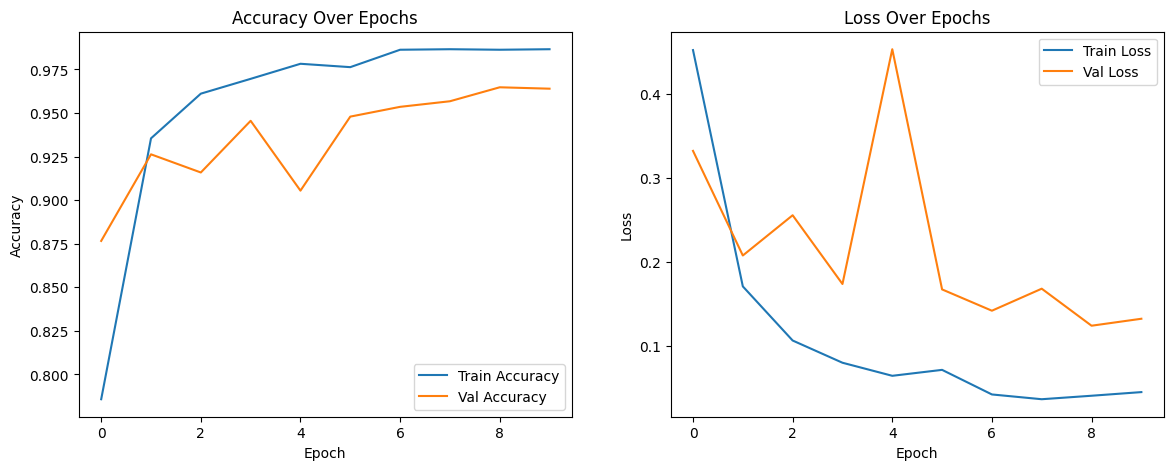


📊 Classification Report:
              precision    recall  f1-score   support

           0     0.9851    0.9519    0.9682       208
           1     0.9567    0.9866    0.9714       224

    accuracy                         0.9699       432
   macro avg     0.9709    0.9693    0.9698       432
weighted avg     0.9704    0.9699    0.9699       432



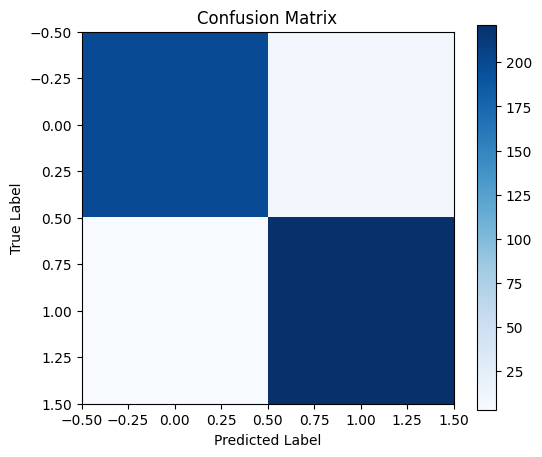

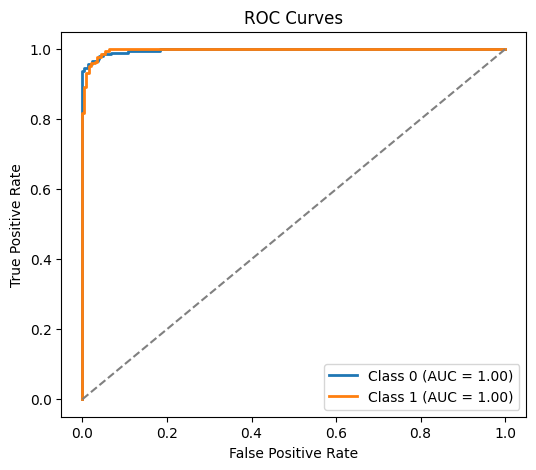

Macro-average ROC-AUC: 0.9971025068681318


In [45]:
# =====================================================
# CELL — Evaluation and Metrics Visualization for ResNet
# =====================================================

import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc, classification_report,
    confusion_matrix, roc_auc_score
)
import numpy as np
import tensorflow as tf


best_model = tf.keras.models.load_model('best_ResNetmodel.keras')

results = best_model.evaluate(test_dataset)
metric_names = best_model.metrics_names

print("\n🔍 Test Metrics:")
for name, value in zip(metric_names, results):
    print(f"{name:15s}: {value:.4f}")


def plot_training_history(history):
    plt.figure(figsize=(14,5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history)


y_true, y_pred = [], []

for images, labels in test_dataset:
    preds = best_model.predict(images, verbose=0)
    y_true.append(labels.numpy())
    y_pred.append(preds)

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

is_multiclass = y_pred.shape[1] > 1 if len(y_pred.shape) > 1 else False

if is_multiclass:
    y_true_classes = np.argmax(y_true, axis=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
else:
    y_true_classes = y_true.astype(int).flatten()
    y_pred_classes = (y_pred > 0.5).astype(int).flatten()


print("\n📊 Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, digits=4))

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC curve (binary)
# -----------------------------------------------------
if is_multiclass:
    plt.figure(figsize=(6,5))
    for i in range(y_true.shape[1]):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0,1], [0,1], '--', color='gray')
    plt.title('ROC Curves')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    print("Macro-average ROC-AUC:",
          roc_auc_score(y_true, y_pred, average='macro', multi_class='ovr'))

else:
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0,1], [0,1], '--', color='gray')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    print(f"ROC-AUC Score: {roc_auc:.4f}")


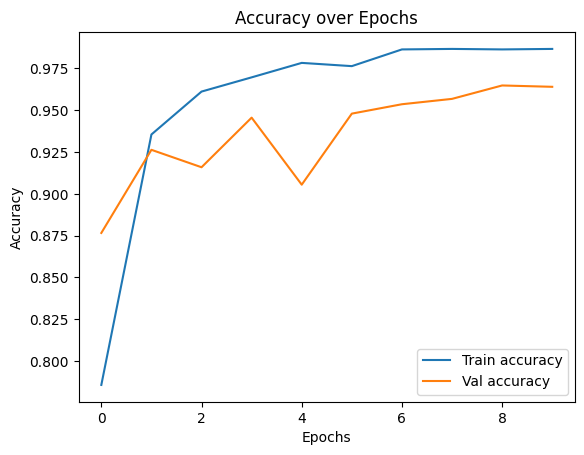

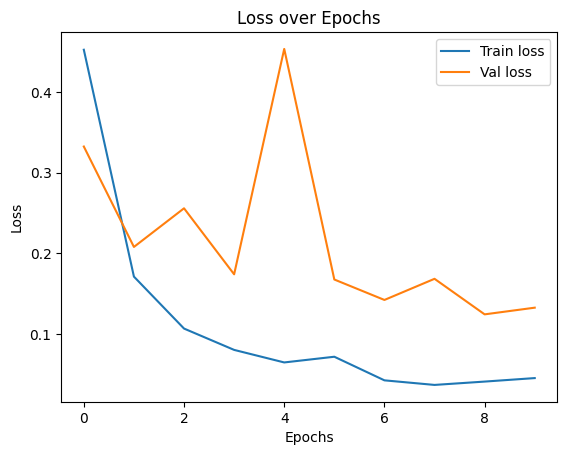

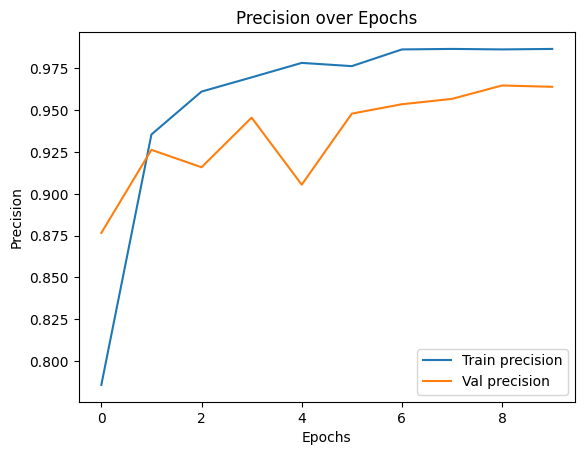

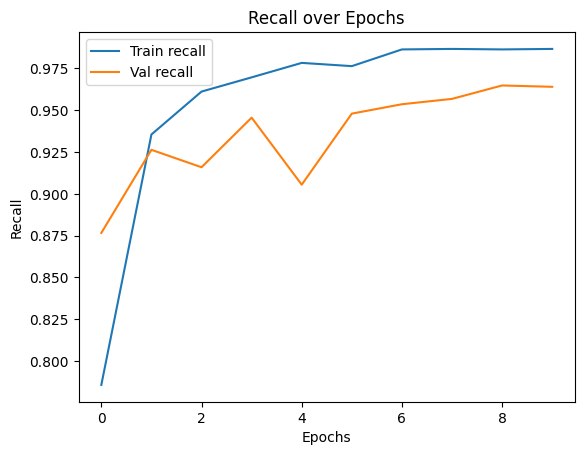

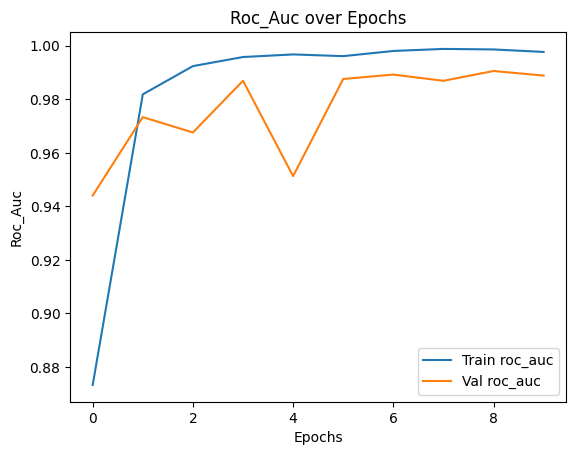

In [46]:
import matplotlib.pyplot as plt

metrics = ['accuracy', 'loss', 'precision', 'recall', 'roc_auc']
for m in metrics:
    plt.figure()
    plt.plot(history.history[m], label=f'Train {m}')
    plt.plot(history.history[f'val_{m}'], label=f'Val {m}')
    plt.title(f'{m.title()} over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(m.title())
    plt.legend()
    plt.show()


In [47]:
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred = ResNet_model.predict(test_dataset)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_true, axis=1)

cm = confusion_matrix(y_true_labels, y_pred_labels)
print(cm)


34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step
[[ 98 103]
 [101 130]]


## MODEL 2

### Transfer learning architecture based on VGG16

In [48]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
import numpy as np

def CNN_model_VGG16():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze all layers initially
    for layer in base_model.layers:
        layer.trainable = False

    unfreeze_from = int(np.round((len(base_model.layers) - 1) * 0.8))
    for layer in base_model.layers[unfreeze_from:]:
        layer.trainable = True

    # classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(2, activation='softmax')(x)  # Binary classification

    model = Model(inputs=base_model.input, outputs=predictions)

    # Display structure info
    print(f"Total layers in VGG16: {len(base_model.layers)}")
    print(f"Frozen layers: {unfreeze_from}")
    print(f"Trainable layers: {len(base_model.layers) - unfreeze_from}")

    return model


In [49]:
from tensorflow.keras.metrics import AUC

VGG_model = CNN_model_VGG16()

VGG_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='roc_auc')]
)

VGG_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Total layers in VGG16: 19
Frozen layers: 14
Trainable layers: 5


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,242,050 (58.14 MB)

 Trainable params: 7,606,786 (29.02 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [50]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

callbacks = [
    ModelCheckpoint('best_vgg16_model.keras', save_best_only=True, monitor='val_accuracy', mode='max'),
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
]

history = VGG_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size=16,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 78s 128ms/step - accuracy: 0.6096 - loss: 0.7051 - precision: 0.6096 - recall: 0.6096 - roc_auc: 0.6394 - val_accuracy: 0.7300 - val_loss: 0.5475 - val_precision: 0.7300 - val_recall: 0.7300 - val_roc_auc: 0.8047 - learning_rate: 1.0000e-04
Epoch 2/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 64s 124ms/step - accuracy: 0.7619 - loss: 0.4864 - precision: 0.7619 - recall: 0.7619 - roc_auc: 0.8458 - val_accuracy: 0.8269 - val_loss: 0.3888 - val_precision: 0.8269 - val_recall: 0.8269 - val_roc_auc: 0.9126 - learning_rate: 1.0000e-04
Epoch 3/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 63s 123ms/step - accuracy: 0.8509 - loss: 0.3329 - precision: 0.8509 - recall: 0.8509 - roc_auc: 0.9325 - val_accuracy: 0.8806 - val_loss: 0.2931 - val_precision: 0.8806 - val_recall: 0.8806 - val_roc_auc: 0.9530 - learning_rate: 1.0000e-04
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 64s 123ms/step - accuracy: 0.9145 - loss: 0.2155 - precision: 0.9145 - recall: 0.9145 - roc_auc: 0.9720 - val_accurac

34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 182ms/step - accuracy: 0.9712 - loss: 0.0987 - precision: 0.9712 - recall: 0.9712 - roc_auc: 0.9917

 Test Metrics:
loss           : 0.0826
compile_metrics: 0.9722


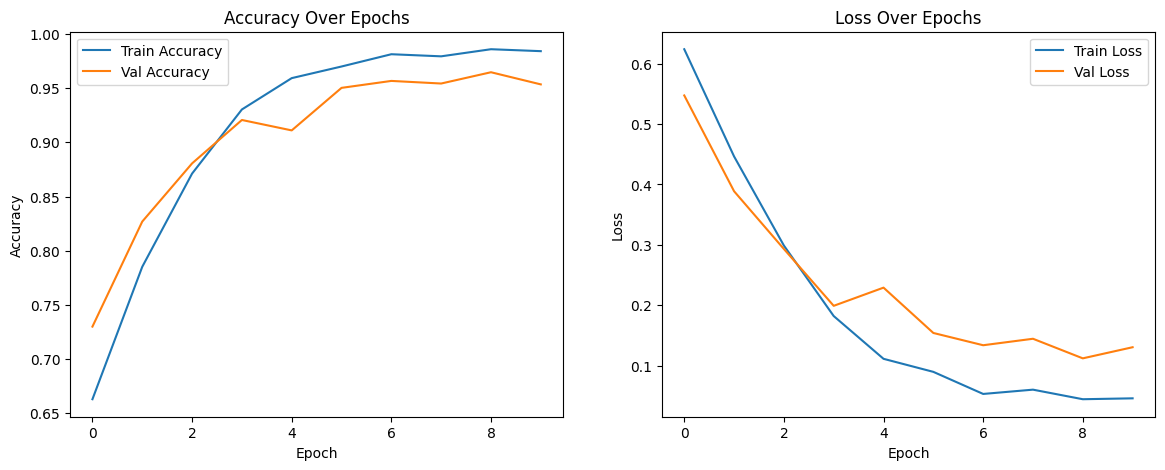


  Classification Report:
              precision    recall  f1-score   support

           0     0.9621    0.9713    0.9667       209
           1     0.9729    0.9641    0.9685       223

    accuracy                         0.9676       432
   macro avg     0.9675    0.9677    0.9676       432
weighted avg     0.9676    0.9676    0.9676       432



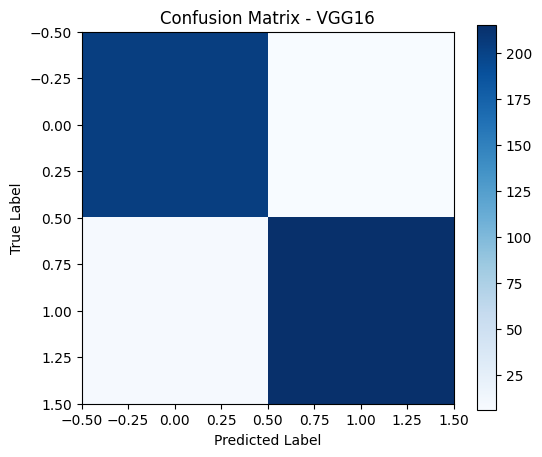

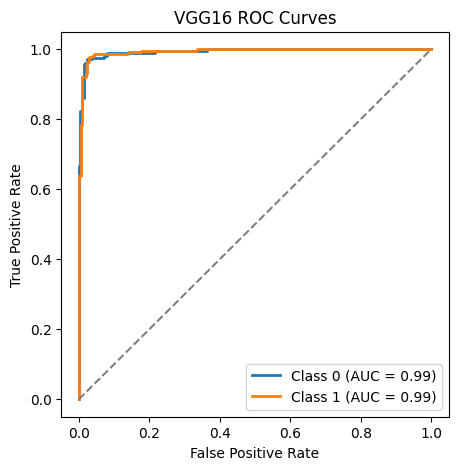

Macro-average ROC-AUC: 0.9933057266075912


In [51]:
# Evaluation and Metrics Visualization for VGG16

import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc, classification_report,
    confusion_matrix, roc_auc_score
)
import numpy as np
import tensorflow as tf


best_vgg_model = tf.keras.models.load_model('best_vgg16_model.keras')

results = best_vgg_model.evaluate(test_dataset)
metric_names = best_vgg_model.metrics_names

print("\n Test Metrics:")
for name, value in zip(metric_names, results):
    print(f"{name:15s}: {value:.4f}")


def plot_training_history(history):
    plt.figure(figsize=(14,5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history)


y_true, y_pred = [], []

for images, labels in test_dataset:
    preds = best_vgg_model.predict(images, verbose=0)
    y_true.append(labels.numpy())
    y_pred.append(preds)

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

is_multiclass = y_pred.shape[1] > 1 if len(y_pred.shape) > 1 else False

if is_multiclass:
    y_true_classes = np.argmax(y_true, axis=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
else:
    y_true_classes = y_true.astype(int).flatten()
    y_pred_classes = (y_pred > 0.5).astype(int).flatten()


print("\n  Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, digits=4))

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix - VGG16")
plt.colorbar()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


if is_multiclass:
    plt.figure(figsize=(5,5))
    for i in range(y_true.shape[1]):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0,1], [0,1], '--', color='gray')
    plt.title('VGG16 ROC Curves')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    print("Macro-average ROC-AUC:",
          roc_auc_score(y_true, y_pred, average='macro', multi_class='ovr'))

else:
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0,1], [0,1], '--', color='gray')
    plt.title('VGG16 ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    print(f"ROC-AUC Score: {roc_auc:.4f}")


In [52]:
test_loss, test_acc, test_prec, test_rec, test_auc = VGG_model.evaluate(test_dataset)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall: {test_rec:.4f}")
print(f"Test ROC-AUC: {test_auc:.4f}")


34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.9566 - loss: 0.1281 - precision: 0.9566 - recall: 0.9566 - roc_auc: 0.9889

Test Accuracy: 0.9699
Test Precision: 0.9699
Test Recall: 0.9699
Test ROC-AUC: 0.9944



🔍 Test Metrics Comparison:
Metric                ResNet        VGG16
----------------------------------------
loss                  0.0701       0.0859
compile_metrics       0.9745       0.9676


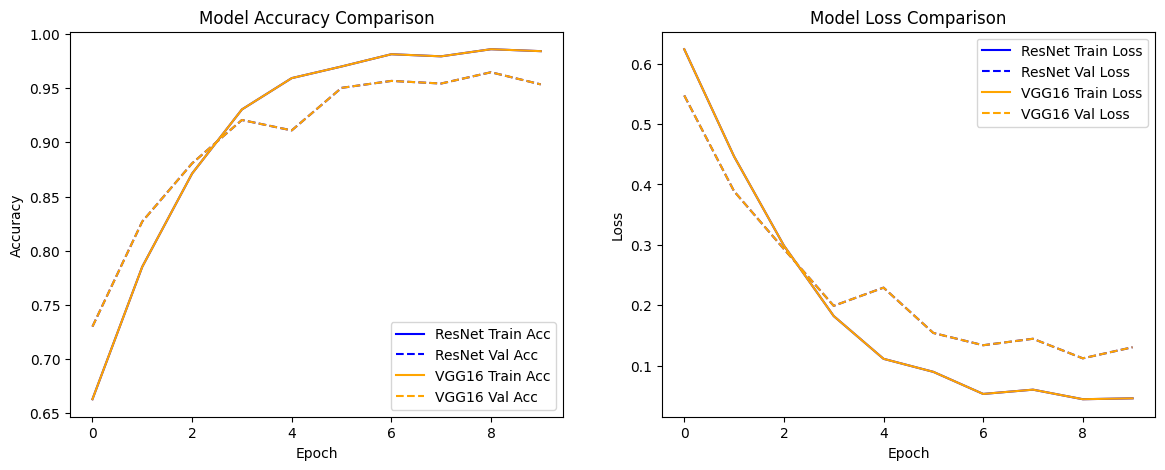

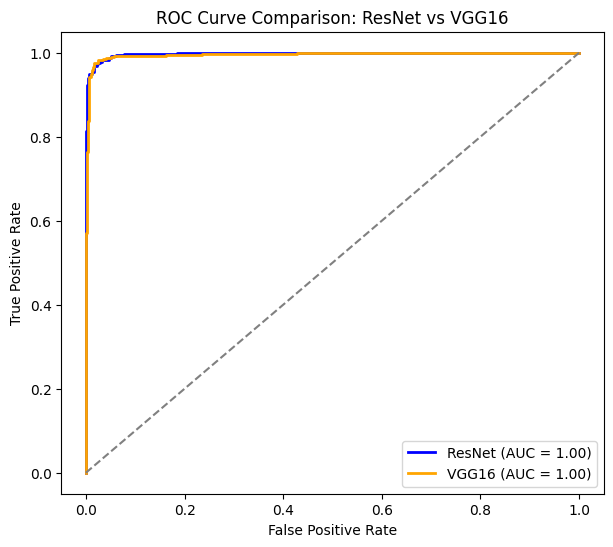


ROC-AUC — ResNet: 0.9977,  VGG16: 0.9955


In [53]:
resnet_model = tf.keras.models.load_model('best_ResNetmodel.keras')
vgg_model = tf.keras.models.load_model('best_vgg16_model.keras')


resnet_results = resnet_model.evaluate(test_dataset, verbose=0)
vgg_results = vgg_model.evaluate(test_dataset, verbose=0)

resnet_metrics = dict(zip(resnet_model.metrics_names, resnet_results))
vgg_metrics = dict(zip(vgg_model.metrics_names, vgg_results))

print("\n🔍 Test Metrics Comparison:")
print(f"{'Metric':<15} {'ResNet':>12} {'VGG16':>12}")
print("-" * 40)
for key in resnet_metrics.keys():
    print(f"{key:<15} {resnet_metrics[key]:>12.4f} {vgg_metrics[key]:>12.4f}")


def compare_training_curves(history_resnet, history_vgg):
    plt.figure(figsize=(14,5))

    
    plt.subplot(1,2,1)
    plt.plot(history_resnet.history['accuracy'], label='ResNet Train Acc', color='blue')
    plt.plot(history_resnet.history['val_accuracy'], label='ResNet Val Acc', color='blue', linestyle='--')
    plt.plot(history_vgg.history['accuracy'], label='VGG16 Train Acc', color='orange')
    plt.plot(history_vgg.history['val_accuracy'], label='VGG16 Val Acc', color='orange', linestyle='--')
    plt.title('Model Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history_resnet.history['loss'], label='ResNet Train Loss', color='blue')
    plt.plot(history_resnet.history['val_loss'], label='ResNet Val Loss', color='blue', linestyle='--')
    plt.plot(history_vgg.history['loss'], label='VGG16 Train Loss', color='orange')
    plt.plot(history_vgg.history['val_loss'], label='VGG16 Val Loss', color='orange', linestyle='--')
    plt.title('Model Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

compare_training_curves(history, history)  


y_true, y_pred_resnet, y_pred_vgg = [], [], []

for images, labels in test_dataset:
    resnet_preds = resnet_model.predict(images, verbose=0)
    vgg_preds = vgg_model.predict(images, verbose=0)
    y_true.append(labels.numpy())
    y_pred_resnet.append(resnet_preds)
    y_pred_vgg.append(vgg_preds)

y_true = np.concatenate(y_true)
y_pred_resnet = np.concatenate(y_pred_resnet)
y_pred_vgg = np.concatenate(y_pred_vgg)

is_multiclass = y_pred_resnet.shape[1] > 1 if len(y_pred_resnet.shape) > 1 else False

plt.figure(figsize=(7,6))

if is_multiclass:
    fpr_r, tpr_r, _ = roc_curve(y_true.ravel(), y_pred_resnet.ravel())
    fpr_v, tpr_v, _ = roc_curve(y_true.ravel(), y_pred_vgg.ravel())
    roc_auc_resnet = auc(fpr_r, tpr_r)
    roc_auc_vgg = auc(fpr_v, tpr_v)

    plt.plot(fpr_r, tpr_r, lw=2, label=f'ResNet (AUC = {roc_auc_resnet:.2f})', color='blue')
    plt.plot(fpr_v, tpr_v, lw=2, label=f'VGG16 (AUC = {roc_auc_vgg:.2f})', color='orange')
else:
    # --- Binary ROC curves ---
    fpr_r, tpr_r, _ = roc_curve(y_true, y_pred_resnet)
    fpr_v, tpr_v, _ = roc_curve(y_true, y_pred_vgg)
    roc_auc_resnet = auc(fpr_r, tpr_r)
    roc_auc_vgg = auc(fpr_v, tpr_v)

    plt.plot(fpr_r, tpr_r, lw=2, label=f'ResNet (AUC = {roc_auc_resnet:.2f})', color='blue')
    plt.plot(fpr_v, tpr_v, lw=2, label=f'VGG16 (AUC = {roc_auc_vgg:.2f})', color='orange')

plt.plot([0,1], [0,1], '--', color='gray')
plt.title('ROC Curve Comparison: ResNet vs VGG16')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

print(f"\nROC-AUC — ResNet: {roc_auc_resnet:.4f},  VGG16: {roc_auc_vgg:.4f}")


# MODEL 3

## Transfer learning and Hybrid ResNet50–ViT with Adapters + Explainability architecture

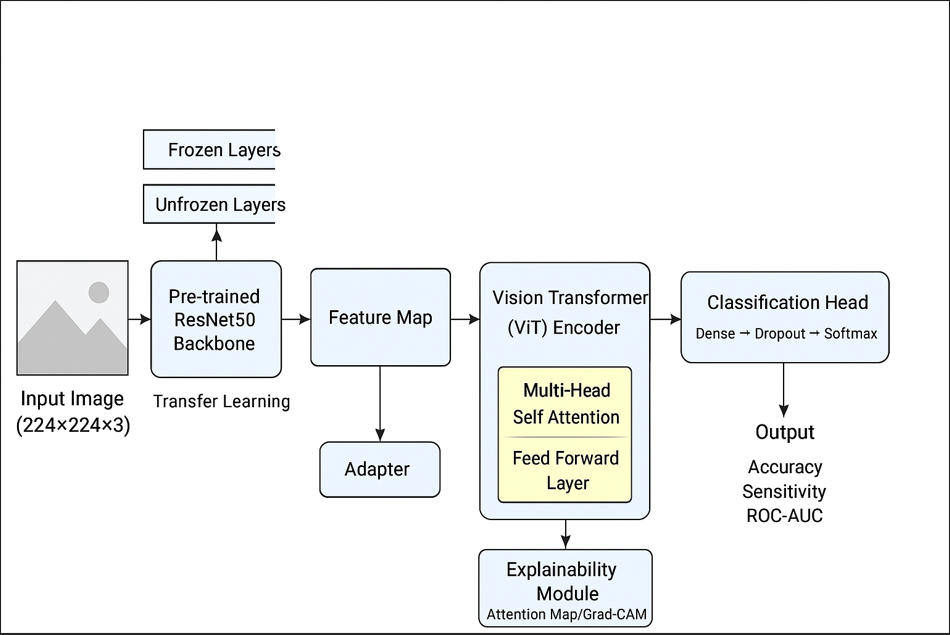

In [54]:
# Cell 1: Imports and Config
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Dense, Dropout, GlobalAveragePooling2D, LayerNormalization, MultiHeadAttention, Add, Input
)
import numpy as np
import matplotlib.pyplot as plt
import random, os

# -------------------
# ✅ Reproducibility
# -------------------
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# -------------------
# ✅ Kaggle GPU Check
# -------------------
gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available:", len(gpus))
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ TensorFlow is using GPU acceleration.")
    except RuntimeError as e:
        print(e)
else:
    print("⚠️ No GPU found. Using CPU.")

# Silence TensorFlow excessive logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


Num GPUs Available: 2
Physical devices cannot be modified after being initialized


In [55]:
# Cell 2: Load Pretrained CNN (ResNet50)
def build_resnet_feature_extractor(trainable_ratio=0.2):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Freeze layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Unfreeze the top X% of layers
    unfreeze_from = int(len(base_model.layers) * (1 - trainable_ratio))
    for layer in base_model.layers[unfreeze_from:]:
        layer.trainable = True
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    feature_extractor = models.Model(inputs=base_model.input, outputs=x, name="ResNet50_FeatureExtractor")
    return feature_extractor

cnn_backbone = build_resnet_feature_extractor(trainable_ratio=0.2)
cnn_backbone.summary()


Model: "ResNet50_FeatureExtractor"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 14,978,048 (57.14 MB)

 Non-trainable params: 8,609,664 (32.84 MB)

In [56]:
# Cell 3
from tensorflow.keras.layers import Conv2D, Reshape, Dense, Layer, Embedding

def get_resnet_feature_map(input_shape=(224,224,3), trainable_ratio=0.2):
    """
    Return a ResNet50 model that outputs the last convolutional feature map
    (shape: 7x7x2048 for input 224x224) while allowing partial unfreezing.
    """
    base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base.layers:
        layer.trainable = False
    unfreeze_from = int(len(base.layers) * (1 - trainable_ratio))
    for layer in base.layers[unfreeze_from:]:
        layer.trainable = True
    # choose the conv5_block3_out feature map
    # find that layer name if stable; fallback to base.output (still conv map)
    try:
        feat = base.get_layer("conv5_block3_out").output
    except Exception:
        feat = base.output
    model = models.Model(inputs=base.input, outputs=feat, name="ResNet50_FeatureMap")
    return model

# patch embedding builder
def build_patch_embedding_layer(patch_size=(1,1), embed_dim=768):
    """
    We use Conv2D with kernel=patch_size and strides=patch_size to create patch tokens.
    For ResNet conv-map (7x7), patch_size=(1,1) results in 7*7 tokens; adjust if you want larger patches.
    """
    class PatchEmbedding(Layer):
        def __init__(self, patch_size=(1,1), embed_dim=768, **kwargs):
            super().__init__(**kwargs)
            self.patch_size = patch_size
            self.embed_dim = embed_dim
            self.proj = Conv2D(filters=embed_dim, kernel_size=patch_size, strides=patch_size, padding='valid')
            self.flatten = Reshape((-1, embed_dim))  # (num_patches, embed_dim)
        def call(self, x):
            x = self.proj(x)           # (B, H/ps, W/ps, embed_dim)
            x = self.flatten(x)       # (B, num_patches, embed_dim)
            return x
        def compute_output_shape(self, input_shape):
            h = input_shape[1] // self.patch_size[0]
            w = input_shape[2] // self.patch_size[1]
            return (input_shape[0], h*w, self.embed_dim)

    return PatchEmbedding(patch_size=patch_size, embed_dim=embed_dim)

resnet_map_model = get_resnet_feature_map()
sample_in = Input(shape=(224,224,3))
fm = resnet_map_model(sample_in)  # e.g., (None, 7, 7, 2048)
patch_layer = build_patch_embedding_layer(patch_size=(1,1), embed_dim=512)
tokens = patch_layer(fm)          # (None, 49, 512)
print("Feature map shape (example):", fm.shape)
print("Tokens shape (example):", tokens.shape)


Feature map shape (example): (None, 7, 7, 2048)
Tokens shape (example): (None, 49, 512)


In [57]:
# Cell 4
from tensorflow.keras import activations

def Adapter(hidden_dim=64, output_dim=None, dropout_rate=0.0, name="Adapter"):
    """
    Returns a Keras layer implementing the adapter block:
    x -> LayerNorm (outside) typically -> Adapter (down -> nonlin -> up) -> residual add
    We'll implement as a Layer subclass so it can be reused easily.
    """
    class _Adapter(Layer):
        def __init__(self, hidden_dim=hidden_dim, output_dim=output_dim, dropout_rate=dropout_rate, **kwargs):
            super().__init__(**kwargs)
            self.hidden_dim = hidden_dim
            self.output_dim = output_dim
            self.dropout_rate = dropout_rate
            # down and up projections; will set output_dim lazily if None
            self.down = None
            self.up = None
            self.act = layers.Activation('gelu')
            self.dropout = Dropout(dropout_rate) if dropout_rate > 0 else None

        def build(self, input_shape):
            out_dim = self.output_dim or int(input_shape[-1])
            self.down = Dense(self.hidden_dim, use_bias=True, name=self.name + "_down")
            self.up = Dense(out_dim, use_bias=True, name=self.name + "_up")
            super().build(input_shape)

        def call(self, x):
            residual = x
            x = self.down(x)
            x = self.act(x)
            if self.dropout is not None:
                x = self.dropout(x)
            x = self.up(x)
            # small scaling may help stability
            return residual + 0.1 * x

        def get_config(self):
            cfg = super().get_config()
            cfg.update({"hidden_dim": self.hidden_dim, "output_dim": self.output_dim, "dropout_rate": self.dropout_rate})
            return cfg

    return _Adapter(hidden_dim=hidden_dim, output_dim=output_dim, dropout_rate=dropout_rate, name=name)

# Quick instantiate
_adapter = Adapter(hidden_dim=128, output_dim=512)
print("Adapter layer instantiated:", _adapter)


Adapter layer instantiated: <_Adapter name=Adapter, built=False>


In [58]:
# Cell 5
from tensorflow.keras.layers import LayerNormalization, Dropout, Dense, Activation

def TransformerEncoderBlock(embed_dim=512, num_heads=8, mlp_dim=2048, dropout_rate=0.1, adapter_hidden=64, name="TransformerBlock"):
    """
    Returns a Layer that implements: 
    x -> LN -> MHA -> Add -> Adapter -> LN -> MLP -> Add -> Adapter
    Also returns the attention scores if return_attn_scores=True at call-time (see below).
    """
    class _Block(Layer):
        def __init__(self, **kwargs):
            super().__init__(**kwargs)
            self.ln1 = LayerNormalization(epsilon=1e-6, name=name + "_ln1")
            self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim//num_heads, name=name + "_mha")
            self.dropout1 = Dropout(dropout_rate)
            self.adapter1 = Adapter(hidden_dim=adapter_hidden, output_dim=embed_dim, name=name + "_adapter1")
            
            self.ln2 = LayerNormalization(epsilon=1e-6, name=name + "_ln2")
            self.ffn_dense1 = Dense(mlp_dim, activation='gelu', name=name + "_ffn1")
            self.ffn_dense2 = Dense(embed_dim, name=name + "_ffn2")
            self.dropout2 = Dropout(dropout_rate)
            self.adapter2 = Adapter(hidden_dim=adapter_hidden, output_dim=embed_dim, name=name + "_adapter2")

        def call(self, x, training=False, return_attn_scores=False):
            # Self-attention
            x_ln = self.ln1(x)
            # Keras MHA can return attention scores when using the functional call signature:
            if return_attn_scores:
                attn_out, attn_scores = self.mha(x_ln, x_ln, return_attention_scores=True)
            else:
                attn_out = self.mha(x_ln, x_ln)
                attn_scores = None
            attn_out = self.dropout1(attn_out, training=training)
            x = x + attn_out
            x = self.adapter1(x)

            # Feed-forward
            y = self.ln2(x)
            y = self.ffn_dense1(y)
            y = self.dropout2(y, training=training)
            y = self.ffn_dense2(y)
            x = x + y
            x = self.adapter2(x)

            if return_attn_scores:
                return x, attn_scores
            return x

        def get_config(self):
            return {}

    return _Block(name=name)

# Quick instantiate test
block = TransformerEncoderBlock(embed_dim=512, num_heads=8, mlp_dim=2048, adapter_hidden=128)
print("Transformer block ready:", block)


Transformer block ready: <_Block name=TransformerBlock, built=False>


In [59]:
# Cell 6: Assemble Hybrid CNN–ViT Model
from tensorflow.keras import Model, layers

# Transformer Encoder Block (same logic)
def transformer_encoder_block(embed_dim, num_heads, mlp_dim, adapter_dim=64):
    inputs = Input(shape=(None, embed_dim))
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
    attn_output = Dropout(0.1)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)

    # Feed-forward network
    ffn = tf.keras.Sequential([
        Dense(mlp_dim, activation='gelu'),
        Dropout(0.1),
        Dense(embed_dim)
    ])
    ffn_output = ffn(out1)

    # Adapter
    adapter_output = Dense(adapter_dim, activation='relu')(ffn_output)
    adapter_output = Dense(embed_dim)(adapter_output)

    out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn_output + adapter_output)
    return Model(inputs=inputs, outputs=out2, name="TransformerEncoderBlock")


# Patch Embedding Layer (CNN → ViT bridge)
def build_patch_embedding(cnn_model, embed_dim=256, patch_size=4):
    inputs = cnn_model.input
    x = cnn_model.output
    x = Dense(embed_dim)(x)
    # wrap expand_dims inside a Lambda layer
    x = layers.Lambda(lambda t: tf.expand_dims(t, axis=1))(x)
    return Model(inputs=inputs, outputs=x, name="PatchEmbedding")


# Assemble full hybrid model
def build_hybrid_model(cnn_backbone, num_classes=2):
    embed_dim = 256
    num_heads = 4
    mlp_dim = 512
    adapter_dim = 64

    patch_embed = build_patch_embedding(cnn_backbone, embed_dim=embed_dim)
    transformer_block = transformer_encoder_block(embed_dim, num_heads, mlp_dim, adapter_dim)

    inputs = patch_embed.input
    x = patch_embed(inputs)
    x = transformer_block(x)

    # Flatten transformer output
    x = layers.Lambda(lambda t: tf.squeeze(t, axis=1))(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=inputs, outputs=outputs, name="Hybrid_ResNet_ViT")


hybrid_model = build_hybrid_model(cnn_backbone)
hybrid_model.summary()


Model: "Hybrid_ResNet_ViT"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ PatchEmbedding (Functional)     │ (None, 1, 256)         │    24,112,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ TransformerEncoderBlock         │ (None, 1, 256)         │     1,348,928 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,461,698 (97.13 MB)

 Trainable params: 16,852,034 (64.29 MB)

 Non-trainable params: 8,609,664 (32.84 MB)

In [60]:
#
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalAveragePooling1D, Dropout, Dense

# --- Parameters
EMBED_DIM = 512       
NUM_HEADS = 8
MLP_DIM = 2048
ADAPTER_DIM = 64
NUM_CLASSES = 2      

# --- Use the ResNet conv feature map model 

try:
    resnet_map_model
except NameError:
    resnet_map_model = get_resnet_feature_map(input_shape=(224,224,3), trainable_ratio=0.2)

# --- Build patch embedding from conv map using your builder (ensure embed_dim matches) ---
patch_layer = build_patch_embedding_layer(patch_size=(1,1), embed_dim=EMBED_DIM)  # uses Conv2D then Reshape
tokens = patch_layer(resnet_map_model.output)   # (B, seq_len, EMBED_DIM)

# --- Instantiate the TransformerEncoderBlock layer 
transformer_layer = TransformerEncoderBlock(embed_dim=EMBED_DIM, num_heads=NUM_HEADS,
                                            mlp_dim=MLP_DIM, dropout_rate=0.1, adapter_hidden=ADAPTER_DIM,
                                            name="TransformerBlock")

# --- A) Build hybrid_model for training/prediction: call transformer_layer WITHOUT attention scores ---
transform_out = transformer_layer(tokens, training=False, return_attn_scores=False)  # returns tensor (B, seq_len, embed_dim)

# Pool + classification head (keeps behavior similar to pipeline)
pooled = GlobalAveragePooling1D(name='gap_tokens')(transform_out)  # (B, embed_dim)
pooled = Dropout(0.3, name='drop_pool')(pooled)
preds = Dense(NUM_CLASSES, activation='softmax', name='preds')(pooled)

hybrid_model = Model(inputs=resnet_map_model.input, outputs=preds, name="Hybrid_ResNet_ViT")
hybrid_model.summary()

# --- B) Build attention_model: call transformer_layer WITH return_attn_scores=True ---
# This re-uses the same transformer_layer weights but creates graph nodes that produce attn_scores
transform_out2, attn_scores = transformer_layer(tokens, training=False, return_attn_scores=True)
# attn_scores shape: (B, num_heads, seq_len, seq_len)

attention_model = Model(inputs=resnet_map_model.input, outputs=attn_scores, name="Hybrid_ResNet_ViT_Attn")
attention_model.summary()


Model: "Hybrid_ResNet_ViT"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 27,922,434 (106.52 MB)

 Trainable params: 19,312,770 (73.67 MB)

 Non-trainable params: 8,609,664 (32.84 MB)

Model: "Hybrid_ResNet_ViT_Attn"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 27,921,408 (106.51 MB)

 Trainable params: 19,311,744 (73.67 MB)

 Non-trainable params: 8,609,664 (32.84 MB)

In [61]:
# CELL 7

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import metrics

# Define metrics for detailed monitoring
custom_metrics = [
    metrics.CategoricalAccuracy(name='accuracy'),
    metrics.Precision(name='precision'),
    metrics.Recall(name='recall'),
    metrics.AUC(name='auc', curve='ROC'),
    metrics.AUC(name='prc', curve='PR')  # Precision-Recall curve metric
]

# Compile the ResNet model
hybrid_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=custom_metrics
)

# Define callbacks for better training management
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_resnet_model.keras',
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Train the model
history = hybrid_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,
    callbacks=[early_stopping, checkpoint]
)


Epoch 1/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6957 - auc: 0.7677 - loss: 0.6874 - prc: 0.7613 - precision: 0.6957 - recall: 0.6957
Epoch 1: val_auc improved from -inf to 0.93325, saving model to best_resnet_model.keras
516/516 ━━━━━━━━━━━━━━━━━━━━ 81s 105ms/step - accuracy: 0.6958 - auc: 0.7679 - loss: 0.6870 - prc: 0.7615 - precision: 0.6958 - recall: 0.6958 - val_accuracy: 0.8502 - val_auc: 0.9333 - val_loss: 0.3757 - val_prc: 0.9305 - val_precision: 0.8502 - val_recall: 0.8502
Epoch 2/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9105 - auc: 0.9689 - loss: 0.2276 - prc: 0.9680 - precision: 0.9105 - recall: 0.9105
Epoch 2: val_auc improved from 0.93325 to 0.96941, saving model to best_resnet_model.keras
516/516 ━━━━━━━━━━━━━━━━━━━━ 48s 92ms/step - accuracy: 0.9106 - auc: 0.9689 - loss: 0.2275 - prc: 0.9680 - precision: 0.9106 - recall: 0.9106 - val_accuracy: 0.9119 - val_auc: 0.9694 - val_loss: 0.2867 - val_prc: 0.9644 - val_precision: 0.9119 - val_r

34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.9678 - auc: 0.9817 - loss: 0.1583 - prc: 0.9773 - precision: 0.9678 - recall: 0.9678

 Test Metrics:
Test Loss:       0.1651
Test Accuracy:   0.9676
Test Precision:  0.9676
Test Recall:     0.9676
Test ROC-AUC:    0.9835
Test PRC-AUC:    0.9795


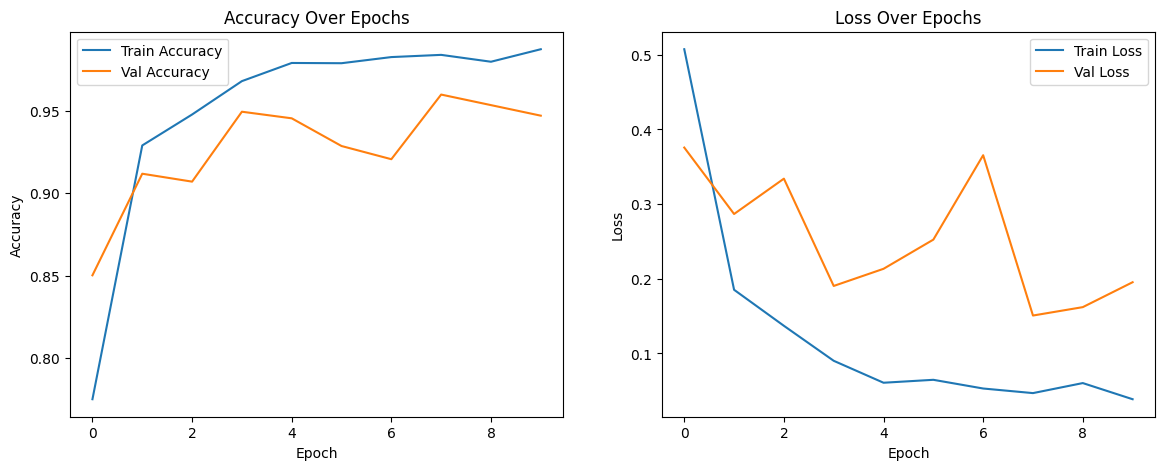


📊 Classification Report:
              precision    recall  f1-score   support

           0     0.9849    0.9561    0.9703       205
           1     0.9614    0.9868    0.9739       227

    accuracy                         0.9722       432
   macro avg     0.9731    0.9714    0.9721       432
weighted avg     0.9725    0.9722    0.9722       432



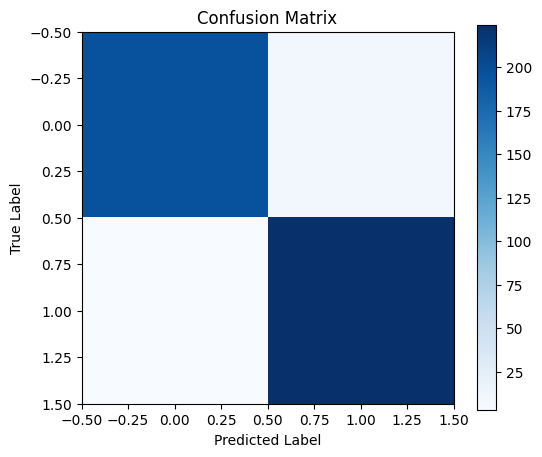

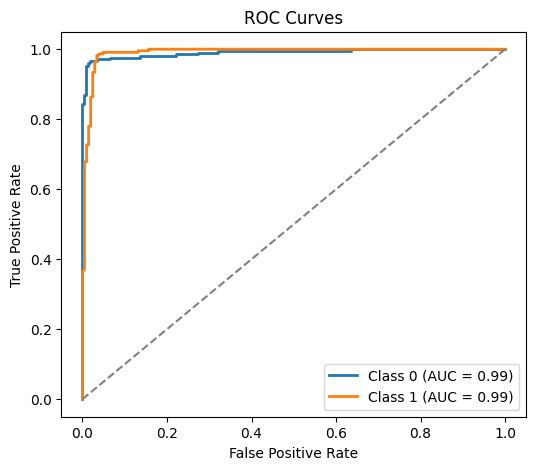

Macro-average ROC-AUC: 0.9907220371763189


In [62]:
from sklearn.metrics import (
    roc_curve, auc, classification_report,
    confusion_matrix, roc_auc_score
)

test_loss, test_acc, test_prec, test_rec, test_auc, test_prc = hybrid_model.evaluate(test_dataset)

print("\n Test Metrics:")
print(f"Test Loss:       {test_loss:.4f}")
print(f"Test Accuracy:   {test_acc:.4f}")
print(f"Test Precision:  {test_prec:.4f}")
print(f"Test Recall:     {test_rec:.4f}")
print(f"Test ROC-AUC:    {test_auc:.4f}")
print(f"Test PRC-AUC:    {test_prc:.4f}")

# Training History Visualization
def plot_training_history(history):
    plt.figure(figsize=(14,5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history)

# Generate predictions for ROC and classification metrics
y_true, y_pred = [], []

for images, labels in test_dataset:
    preds = hybrid_model.predict(images, verbose=0)
    y_true.append(labels.numpy())
    y_pred.append(preds)

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# Convert one-hot labels to class indices
y_true_classes = np.argmax(y_true, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# 4️⃣ Classification report & confusion matrix
print("\n📊 Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, digits=4))

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC curve (binary or multiclass)

if y_true.shape[1] > 1:
    # --- Multiclass: one-vs-rest ROC curves ---
    plt.figure(figsize=(6,5))
    for i in range(y_true.shape[1]):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0,1], [0,1], '--', color='gray')
    plt.title('ROC Curves')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    print("Macro-average ROC-AUC:",
          roc_auc_score(y_true, y_pred, average='macro', multi_class='ovr'))

else:
    # --- Binary ROC curve ---
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0,1], [0,1], '--', color='gray')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()


In [63]:
test_loss, test_acc, test_prec, test_rec, test_auc, test_prc = hybrid_model.evaluate(test_dataset)

print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall: {test_rec:.4f}")
print(f"Test ROC-AUC: {test_auc:.4f}")
print(f"Test PR-AUC (PRC): {test_prc:.4f}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9786 - auc: 0.9908 - loss: 0.1107 - prc: 0.9889 - precision: 0.9786 - recall: 0.9786

Test Accuracy: 0.9722
Test Precision: 0.9722
Test Recall: 0.9722
Test ROC-AUC: 0.9864
Test PR-AUC (PRC): 0.9831


In [64]:
# Debug: print shapes/names
print("resnet_map_model.output_shape:", resnet_map_model.output_shape)
print("patch_layer:", patch_layer.name, "-> output shape (call on sample):", patch_layer(resnet_map_model.output).shape)
print("transformer_layer name:", transformer_layer.name)
# build nodes (not evaluate)
o1 = transformer_layer(patch_layer(resnet_map_model.output), training=False, return_attn_scores=True)
print("transformer_layer returned shapes/types:", [type(o) for o in o1])


resnet_map_model.output_shape: (None, 7, 7, 2048)
patch_layer: patch_embedding_1 -> output shape (call on sample): (None, 49, 512)
transformer_layer name: TransformerBlock
transformer_layer returned shapes/types: [<class 'keras.src.backend.common.keras_tensor.KerasTensor'>, <class 'keras.src.backend.common.keras_tensor.KerasTensor'>]


In [65]:
import os

# Change this to your actual image directory
image_dir = "/kaggle/working/merged_images/1"

# List available files
print("Available images:", os.listdir(image_dir)[:10])  # show first 10


Available images: ['c4c041c70c3c4125b27a17ddbabfdf6a_1-161_aug2275.jpg', '72a0e8754c464e21925b312de185fc5d_1-287_aug170.jpg', '2f27a4a6299e4c32a26cabfbcbf1b3bd_1-042.jpg', '0b60290890ca46e5a2a4d7bec3710f92_1-065_aug67.jpg', '4bde745886c443c2a0c6c76fe1b7080a_1-079_aug181.jpg', 'e9fb2f07d0b840e38f503bce55dd6ec6_1-179_aug479.jpg', '59c9fce347704a60ad7a816235491b71_1-279_aug994.jpg', 'c1310cad2ce848acb4fc32a424fced60_1-080_aug1483.jpg', 'd549bcf491b6481ea20915ff1e2522d0_1-077_aug898.jpg', '5b981d819d0541cab1949e2d60dddc35_1-100_aug2254.jpg']


### Explainability

Selected image: /kaggle/working/merged_images/1/bd997e250ba8417c9c7f8cb2b5fe0cb1_1-073_aug333.jpg


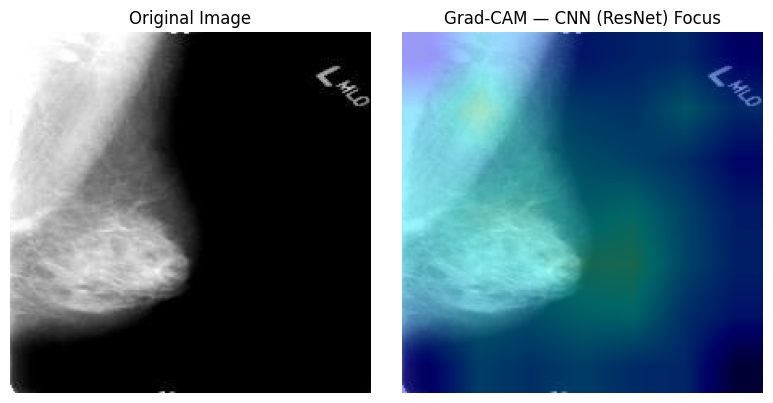

In [66]:


# Helper: load + preprocess image
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    return img_array, img

# Grad-CAM heatmap generator (ResNet backbone only)
def make_gradcam_heatmap(img_array, cnn_backbone):
    # Find the last convolutional layer safely
    last_conv_layer = None
    for layer in reversed(cnn_backbone.layers):
        try:
            if len(layer.output.shape) == 4:
                last_conv_layer = layer
                break
        except:
            continue

    if last_conv_layer is None:
        raise ValueError(" No convolutional layer found inside CNN backbone.")

    # Define grad model
    grad_model = Model(
        inputs=cnn_backbone.input,
        outputs=[last_conv_layer.output, cnn_backbone.output],
    )

    # Compute gradients
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array)
        class_idx = tf.argmax(preds[0])
        loss = preds[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    # Compute heatmap
    heatmap = tf.reduce_mean(conv_outputs * pooled_grads, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= (np.max(heatmap) + 1e-8)
    heatmap = heatmap.numpy() if isinstance(heatmap, tf.Tensor) else heatmap
    return heatmap

# Display explainability overlay
def display_explainability(img_path, cnn_backbone):
    img_array, orig_img = load_and_preprocess_image(img_path)
    heatmap = make_gradcam_heatmap(img_array, cnn_backbone)

    # Resize & overlay heatmap
    heatmap = cv2.resize(heatmap, (orig_img.size[0], orig_img.size[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(np.array(orig_img), 0.6, heatmap, 0.4, 0)

    # Plot results
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(orig_img)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title("Grad-CAM — CNN (ResNet) Focus")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


def get_random_image_path(base_dir):
    cls = random.choice(os.listdir(base_dir))
    cls_dir = os.path.join(base_dir, cls)
    img_name = random.choice(os.listdir(cls_dir))
    return os.path.join(cls_dir, img_name)

# Run explainability
sample_image_path = get_random_image_path("/kaggle/working/merged_images")
print("Selected image:", sample_image_path)
display_explainability(sample_image_path, cnn_backbone)


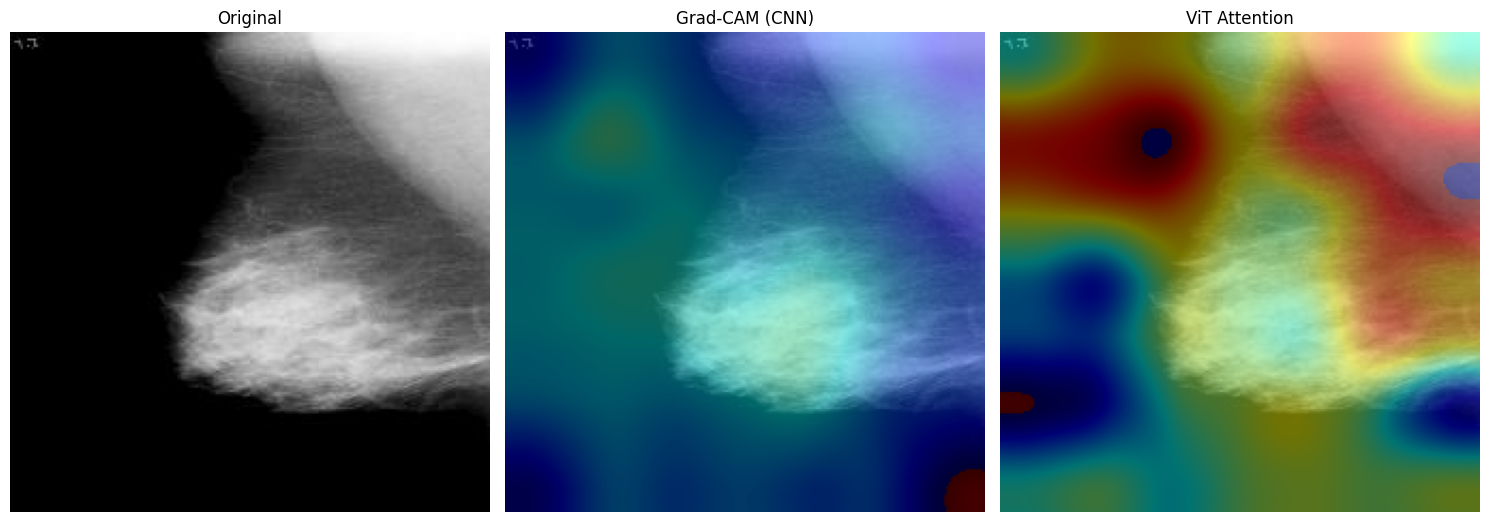

In [67]:

def get_vit_attention_overlay_from_attention_model(img_path, attention_model, resnet_map_model,
                                                   target_size=(224,224), alpha=0.45):
    """
    Returns an RGB numpy image of the original image with ViT attention overlay.
    attention_model: model(image_norm_0_1) -> (1, heads, seq, seq)
    resnet_map_model: used to infer H,W for token grid (resnet conv map shape)
    """
    img_arr, pil_img = load_and_preprocess_image(img_path, target_size=target_size)  # img_arr already /255
    # attention_model expects same scaling; call predict
    attn = attention_model.predict(img_arr, verbose=0)   # (1, heads, seq, seq)
    if attn.ndim != 4:
        raise ValueError(f"Unexpected attention shape: {attn.shape}")

    # avg over heads -> (seq, seq)
    attn_avg = np.mean(attn[0], axis=0)
    # per-token importance: mean attention received by token (columns)
    per_token = np.mean(attn_avg, axis=0)   # (seq,)
    per_token = per_token - per_token.min()
    if per_token.max() > 0:
        per_token = per_token / per_token.max()

    # infer H,W from resnet_map_model output shape if available
    try:
        fm_shape = resnet_map_model.output_shape  # (None, H, W, C)
        H, W = int(fm_shape[1]), int(fm_shape[2])
    except Exception:
        # fallback to square
        seq_len = per_token.shape[0]
        side = int(sqrt(seq_len))
        H = W = side

    if H * W != per_token.shape[0]:
        # fallback to square reshape if something odd
        side = int(sqrt(per_token.shape[0]))
        if side * side == per_token.shape[0]:
            H = W = side
        else:
            raise ValueError(f"Per-token length {per_token.shape[0]} does not match H*W ({H}x{W})")

    attn_grid = per_token.reshape(H, W)               # (H, W)
    attn_up = cv2.resize(attn_grid, (target_size[1], target_size[0]), interpolation=cv2.INTER_CUBIC)
    attn_uint8 = np.uint8(255 * attn_up)
    attn_colored = cv2.applyColorMap(attn_uint8, cv2.COLORMAP_JET)

    # read original (RGB)
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # overlay
    overlay = cv2.addWeighted(img_rgb, 1 - alpha, attn_colored, alpha, 0)
    return overlay

def display_gradcam_and_vit(img_path, cnn_backbone, attention_model, resnet_map_model,
                            target_size=(224,224), alpha_vit=0.45):
    img_arr_for_gradcam, pil = load_and_preprocess_image(img_path, target_size=target_size)  # img_arr is 0..1
    heatmap = make_gradcam_heatmap(img_arr_for_gradcam, cnn_backbone)   # (Hc, Wc)

    # Resize heatmap to image and make overlay
    heatmap_resized = cv2.resize(heatmap, (pil.size[0], pil.size[1]), interpolation=cv2.INTER_CUBIC)
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    gradcam_overlay = cv2.addWeighted(np.array(pil), 0.6, heatmap_colored, 0.4, 0)

    # 2) ViT attention overlay using attention_model
    vit_overlay = get_vit_attention_overlay_from_attention_model(img_path, attention_model, resnet_map_model,
                                                                 target_size=target_size, alpha=alpha_vit)

    # 3) Display side-by-side
    plt.figure(figsize=(15,6))
    plt.subplot(1,3,1)
    plt.imshow(pil)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(gradcam_overlay)
    plt.title("Grad-CAM (CNN)")
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(vit_overlay)
    plt.title("ViT Attention")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

folder = "/kaggle/working/merged_images/0"

# Get all files in the folder
files = os.listdir(folder)

# Keep only image files
image_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

if len(image_files) == 0:
    raise ValueError(f"No images found in {folder}")

# Pick the first image
sample_image_path = os.path.join(folder, image_files[0])

# run
display_gradcam_and_vit(sample_image_path, cnn_backbone, attention_model, resnet_map_model)